# Parte 1: 

In [2]:
# === BIBLIOTECAS NECESSÁRIAS ===
# Manipulação de dados e cálculos numéricos
import pandas as pd 
import numpy as np  
# Visualização estática (gráficos tradicionais)
import matplotlib.pyplot as plt 
import seaborn as sns  
from scipy import stats          
# Manipulação de datas
from datetime import datetime  
# Visualização interativa e dinâmica
import plotly.express as px     
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 
# Manipulação de arquivos e sistemas
import glob
import os  
# Expressões regulares
import re 

In [3]:
# 1) Carregar e concatenar os dados dos processos judiciais da pasta uploads
# Exibição no console
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 200)

# Listar os arquivos CSV na pasta 'uploads'
arquivos_csv = glob.glob('uploads/processos_*.csv')

# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
tamanho_total_bytes = 0   # Somar os tamanhos dos arquivos
for arquivo in arquivos_csv:
    # Extrair o ano do nome do arquivo
    ano = int(arquivo.split('_')[-1].split('.')[0])
    
    # Soma o tamanho de cada arquivo à variável
    tamanho_total_bytes += os.path.getsize(arquivo)
    
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    df_ano['ano_arquivo'] = ano  # Adicionar coluna com o ano do arquivo
    dfs.append(df_ano)

print("\n=== Arquivo carregado com sucesso! ===")
df_juridico = pd.concat(dfs, ignore_index=True)
print("- Dimensões (linhas, colunas):", df_juridico.shape)

# Tamanho do arquivo
file_size_mb = tamanho_total_bytes / (1024**2)
print(f"- Tamanho total dos arquivos CSV no disco: {file_size_mb:.2f} MB")

# Verificação de valores vazios ou nulos no DataFrame df_juridico
print("\n" + "="*100)
print("=== Verificação de Valores Nulos/Vazios ===")
print("="*100 + "\n")

# Contar o total de valores nulos por coluna
valores_nulos_por_coluna = df_juridico.isnull().sum()

# Filtrar para mostrar apenas as colunas que de fato contêm valores nulos
colunas_com_nulos = valores_nulos_por_coluna[valores_nulos_por_coluna > 0]

if colunas_com_nulos.empty:
    print("Não foram encontrados valores nulos ou vazios no DataFrame.")
else:
    print("- Foram encontrados valores nulos nas seguintes colunas:")
    
    # Criar um DataFrame de resumo para uma visualização clara
    total_registros = len(df_juridico)
    df_resumo_nulos = pd.DataFrame({
        'Qtd Nulos': colunas_com_nulos,
        'Percentual (%)': (colunas_com_nulos / total_registros) * 100
    })
    
    # Ordenar o resultado pela coluna de percentual, do maior para o menor
    df_resumo_nulos_sorted = df_resumo_nulos.sort_values(by='Percentual (%)', ascending=False)
    
    # Formatar a coluna de percentual para exibir com duas casas decimais e o símbolo '%'
    df_resumo_nulos_sorted['Percentual (%)'] = df_resumo_nulos_sorted['Percentual (%)'].map('{:.2f}%'.format)
    
    # Exibir a tabela-resumo
    print(df_resumo_nulos_sorted)
    print("\n" + "="*100 + "\n")

# Guardar uma cópia de trabalho
df = df_juridico.copy()


=== Arquivo carregado com sucesso! ===
- Dimensões (linhas, colunas): (4944351, 11)
- Tamanho total dos arquivos CSV no disco: 726.09 MB

=== Verificação de Valores Nulos/Vazios ===

- Foram encontrados valores nulos nas seguintes colunas:
             Qtd Nulos Percentual (%)
data_baixa     1749238         35.38%
codg_classe          2          0.00%




In [4]:
# 2) Tratamento dos Dados para Advogados
# Tratamento das colunas
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['ano_distribuicao'] = df['data_distribuicao'].dt.year # Criar coluna de ano de distribuição
df['is_segredo_justica'] = df['is_segredo_justica'].astype(bool)

# Tratamento dos números de OAB
def is_oab_valida(oab):
    """
    Verifica se um número de OAB é válido seguindo o formato:
    NÚMEROS + LETRA + ESPAÇO + UF. Ex: '2153421N GO'
    """
    if not isinstance(oab, str) or not oab.strip():
        return False
    oab_limpa = oab.upper().strip()
    ufs_validas = ['GO', 'DF', 'SP', 'RJ', 'MG', 'RS', 'SC', 'PR', 'BA', 'PE',
                  'CE', 'MA', 'ES', 'AL', 'SE', 'PB', 'RN', 'PI', 'MT', 'MS', 
                  'TO', 'PA', 'AP', 'AM', 'RR', 'AC', 'RO'
                  ]
    padrao_regex = re.compile(f"^[1-9]\\d*[A-Z]\\s({'|'.join(ufs_validas)})$")
    return bool(padrao_regex.match(oab_limpa))

# Aplicar a validação de OAB
df['oab_valida'] = df['oab'].apply(is_oab_valida)

# Contar e exibir a quantidade de OABs inválidas
registros_invalidos = df[df['oab_valida'] == False]
qtd_invalidos = len(registros_invalidos)

print("\n" + "="*100)
print("=== Validação de Registros de OAB ===")
print("="*100 + "\n")
print(f"- Total de registros com OAB em formato inválido ou nulo: {qtd_invalidos}")

if qtd_invalidos > 0:
    exemplos_invalidos = registros_invalidos['oab'].unique()
    print(f"- Exemplos de OABs inválidas: {exemplos_invalidos}")


# Dataframe com apenas OABs válidas
df_validos = df[df['oab_valida'] == True].copy()

# Verificar se valores NULL ou Vazios
print("\n" + "="*100)
print("=== Dataframe com apenas OAB's válidas ===")
print("="*100 + "\n")

display(df_validos.head())
print("\n" + "="*100 + "\n")


=== Validação de Registros de OAB ===

- Total de registros com OAB em formato inválido ou nulo: 20335
- Exemplos de OABs inválidas: ['GO' '0A RJ' '0A MT' '0S GO' '0A MG' '0S MT' '0S DF' '0S MA' '0A PE' 'TO'
 '0A MS' '0S AL' '0S CE' '0S SC' '0S MG' '0S MS' '0S RS' '0S RN' '0A TO'
 '0A SE' '0S PE' '0A RS' '0S TO']

=== Dataframe com apenas OAB's válidas ===



,processo,data_distribuicao,data_baixa,entrancia,comarca,serventia,is_segredo_justica,codg_classe,oab,codg_assunto,ano_arquivo,ano_distribuicao,oab_valida
0,0119071.75.2004.8.09.0051,2022-05-25,2022-06-30,FINAL,GOIÂNIA,2ª Vara Cível,False,7.0,19365N GO,10671,2022,2022,True
1,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,10647N GO,10671,2022,2022,True
2,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,167974A SP,10671,2022,2022,True
3,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,20763N GO,10671,2022,2022,True
4,0197944.89.2004.8.09.0051,2022-06-07,2022-10-07,FINAL,GOIÂNIA,22ª Vara Cível,False,7.0,20785N GO,10671,2022,2022,True


In [5]:
# 3) Análise de Processos Sigilosos e Não Sigilosos por OAB válida
# Agrupar por 'oab' e 'is_segredo_justica' e contar a quantidade de processos
df_analise = df_validos.groupby(['oab', 'is_segredo_justica']).size().reset_index(name='qtd_processos')

# Ordenar os resultados para melhor visualização (pela OAB e depois pela quantidade)
df_analise_sorted = df_analise.sort_values(by=['oab', 'qtd_processos'], ascending=[True, False])

print("\n" + "="*100)
print("=== Tabela de Processos Sigilosos e Não Sigilosos por OAB ===")
print("="*100 + "\n")
display(df_analise_sorted.head(10))

# Para uma visualização mais clara, "pivotei" a tabela
# Criando colunas separadas para processos sigilosos e não sigilosos
df_pivot = df_analise.pivot_table(
    index='oab',
    columns='is_segredo_justica',
    values='qtd_processos',
    fill_value=0 # Preenche com 0 OABs que não têm um dos tipos
)

# Renomear as colunas (False -> nao_sigilosos, True -> sigilosos)
df_pivot = df_pivot.rename(columns={False: 'nao_sigilosos', True: 'sigilosos'})

# Adicionar uma coluna de total e ordenar pelos advogados com mais processos
df_pivot['total_processos'] = df_pivot['nao_sigilosos'] + df_pivot['sigilosos']
df_pivot_sorted = df_pivot.sort_values(by='total_processos', ascending=False)

print("\n" + "="*100)
print("=== Tabela Pivotada: Contagem por OAB ===")
print("="*100 + "\n")
display(df_pivot_sorted.head(10))



=== Tabela de Processos Sigilosos e Não Sigilosos por OAB ===



,oab,is_segredo_justica,qtd_processos
0,100005A PR,False,8
1,100006A PR,False,2
2,100006S RS,False,17
3,100008A RJ,True,1
4,10000N GO,False,16
5,100018A RS,False,1
6,10001A DF,False,1
7,10001A MS,False,1
8,10001A TO,False,1
9,10001N GO,False,58



=== Tabela Pivotada: Contagem por OAB ===



is_segredo_justica,nao_sigilosos,sigilosos,total_processos
oab,,,
16315N GO,86839.0,439.0,87278.0
21735N GO,71783.0,1548.0,73331.0
40240N GO,69514.0,1239.0,70753.0
38664N GO,43965.0,3617.0,47582.0
36056N GO,29732.0,518.0,30250.0
28449A GO,28525.0,683.0,29208.0
9632N GO,28435.0,4.0,28439.0
19417N GO,28226.0,3.0,28229.0
31989N GO,25473.0,232.0,25705.0


In [6]:
# 4) Cálculo de Estatísticas Descritivas (Medidas de Tendência Central)
print("\n" + "="*100)
print("=== ESTATÍSTICAS DESCRITIVAS DE PROCESSOS POR OAB VÁLIDA ===")
print("="*100 + "\n")

# Análise Geral (Total de Processos)
# Distribuição do número total de processos por advogado.
print("--- Análise Geral (Total de Processos por OAB) ---")
total_counts = df_pivot_sorted['total_processos']

# Cálculo das métricas
media_geral = total_counts.mean()
mediana_geral = total_counts.median()
moda_geral = total_counts.mode()

print(f"- Média de processos por OAB: {media_geral:.2f}")
print(f"- Mediana de processos por OAB: {mediana_geral}")
# A moda pode retornar múltiplos valores se houver empate; pegamos o primeiro.
if not moda_geral.empty:
    print(f"- Moda de processos por OAB: {moda_geral.iloc[0]}")
else:
    print("- Moda: Não há um valor único que seja o mais frequente.")


# Análise de Processos NÃO SIGILOSOS
# Foco na distribuição de processos públicos por advogado.
print("\n--- Análise de Processos NÃO SIGILOSOS por OAB ---")
nao_sigilosos_counts = df_pivot_sorted['nao_sigilosos']

# Cálculo das métricas
media_nao_sigilosos = nao_sigilosos_counts.mean()
mediana_nao_sigilosos = nao_sigilosos_counts.median()
moda_nao_sigilosos = nao_sigilosos_counts.mode()

print(f"- Média de processos não sigilosos por OAB: {media_nao_sigilosos:.2f}")
print(f"- Mediana de processos não sigilosos por OAB: {mediana_nao_sigilosos}")
if not moda_nao_sigilosos.empty:
    print(f"- Moda de processos não sigilosos por OAB: {moda_nao_sigilosos.iloc[0]}")
else:
    print("- Moda: Não há um valor único que seja o mais frequente.")


# Análise de Processos SIGILOSOS
# Foco na distribuição de processos em segredo de justiça por advogado.
print("\n--- Análise de Processos SIGILOSOS por OAB ---")
sigilosos_counts = df_pivot_sorted['sigilosos']

# Cálculo das métricas
media_sigilosos = sigilosos_counts.mean()
mediana_sigilosos = sigilosos_counts.median()
moda_sigilosos = sigilosos_counts.mode()

print(f"- Média de processos sigilosos por OAB: {media_sigilosos:.2f}")
print(f"- Mediana de processos sigilosos por OAB: {mediana_sigilosos}")
if not moda_sigilosos.empty:
    print(f"- Moda de processos sigilosos por OAB: {moda_sigilosos.iloc[0]}")
else:
    print("- Moda: Não há um valor único que seja o mais frequente.")


=== ESTATÍSTICAS DESCRITIVAS DE PROCESSOS POR OAB VÁLIDA ===

--- Análise Geral (Total de Processos por OAB) ---
- Média de processos por OAB: 43.27
- Mediana de processos por OAB: 3.0
- Moda de processos por OAB: 1.0

--- Análise de Processos NÃO SIGILOSOS por OAB ---
- Média de processos não sigilosos por OAB: 36.71
- Mediana de processos não sigilosos por OAB: 3.0
- Moda de processos não sigilosos por OAB: 1.0

--- Análise de Processos SIGILOSOS por OAB ---
- Média de processos sigilosos por OAB: 6.56
- Mediana de processos sigilosos por OAB: 0.0
- Moda de processos sigilosos por OAB: 0.0



=== VISUALIZAÇÃO GRÁFICA DAS MEDIDAS DE TENDÊNCIA CENTRAL ===



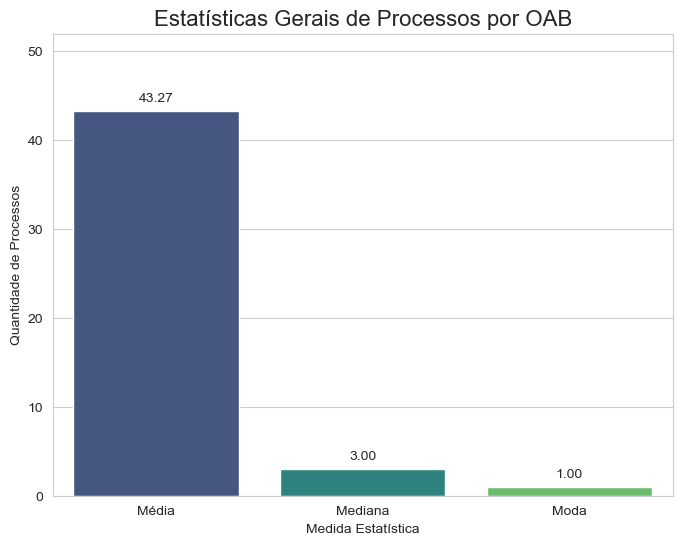

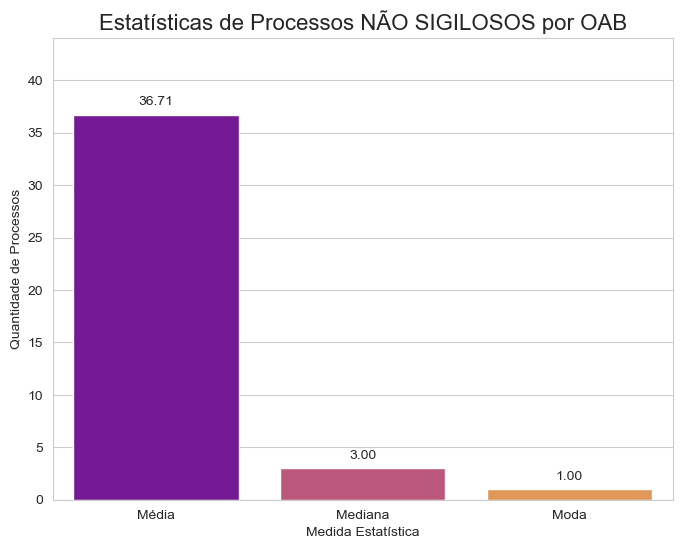

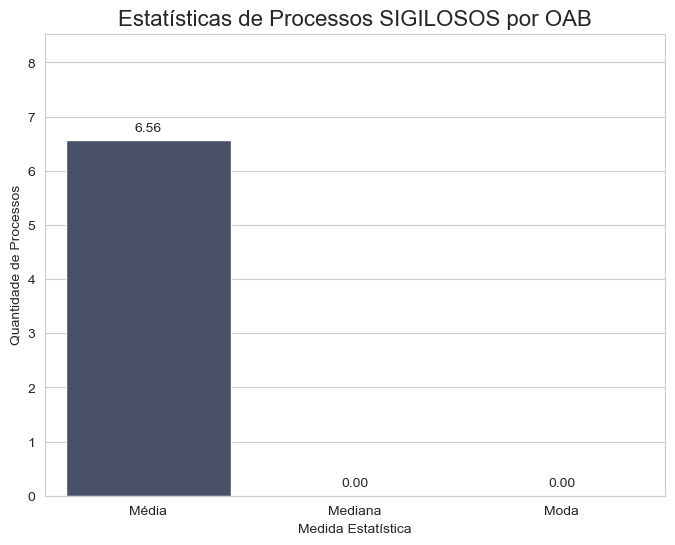

In [7]:
# 5) Visualização Gráfica das Estatísticas
# Configurar um estilo estético para os gráficos
sns.set_style("whitegrid")
# A paleta de cores será definida dentro de cada gráfico

print("\n" + "="*100)
print("=== VISUALIZAÇÃO GRÁFICA DAS MEDIDAS DE TENDÊNCIA CENTRAL ===")
print("="*100 + "\n")

# --- 5.1) Gráfico para Análise Geral ---

# Preparar os dados para o gráfico
dados_geral = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_geral, mediana_geral, moda_geral.iloc[0] if not moda_geral.empty else 0]
}
df_plot_geral = pd.DataFrame(dados_geral)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_geral = sns.barplot(x='Métrica', y='Valor', data=df_plot_geral, palette='viridis', hue='Métrica')


# Adicionar o valor exato no topo de cada coluna
for p in ax_geral.patches:
    ax_geral.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.title('Estatísticas Gerais de Processos por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_geral * 1.2)
plt.show()


# --- 5.2) Gráfico para Processos NÃO SIGILOSOS ---

# Preparar os dados para o gráfico
dados_nao_sigilosos = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_nao_sigilosos, mediana_nao_sigilosos, moda_nao_sigilosos.iloc[0] if not moda_nao_sigilosos.empty else 0]
}
df_plot_nao_sigilosos = pd.DataFrame(dados_nao_sigilosos)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_nao_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_nao_sigilosos, palette='plasma', hue='Métrica')

# Adicionar o valor exato no topo de cada coluna
for p in ax_nao_sigiloso.patches:
    ax_nao_sigiloso.annotate(f'{p.get_height():.2f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')

plt.title('Estatísticas de Processos NÃO SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_nao_sigilosos * 1.2)
plt.show()


# --- 5.3) Gráfico para Processos SIGILOSOS ---

# Preparar os dados para o gráfico
dados_sigilosos = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_sigilosos, mediana_sigilosos, moda_sigilosos.iloc[0] if not moda_sigilosos.empty else 0]
}
df_plot_sigilosos = pd.DataFrame(dados_sigilosos)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_sigilosos, palette='cividis', hue='Métrica')

# Adicionar o valor exato no topo de cada coluna
for p in ax_sigiloso.patches:
    ax_sigiloso.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

plt.title('Estatísticas de Processos SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_sigilosos * 1.3)
plt.show()


# 📊 Análise Interpretativa dos Resultados Estatísticos (Média, Mediana e Moda)

## 💡 Interpretação Geral

A conclusão mais importante, que é vista nos três casos, é a existência de uma **distribuição de processos extremamente assimétrica e desigual**. Em outras palavras, há uma concentração massiva de processos em um número relativamente pequeno de advogados, enquanto a grande maioria dos advogados atua em pouquíssimos casos.

Esse fenômeno é claramente indicado pela **enorme diferença entre a MÉDIA e a MEDIANA/MODA**.

- A **Média** é muito sensível a valores extremos (outliers).
- A **Mediana** e a **Moda** representam melhor o advogado "típico" ou o cenário "mais comum".

> Quando a média é muito maior que a mediana, como é o caso, isso significa que existem alguns "pontos fora da curva" com valores altíssimos que estão "puxando" a média para cima.

---

## 🔎 Análise Detalhada dos Resultados

### ⚖️ 1. Análise Geral (Total de Processos por OAB)

* **⭐ Moda de 1.0:** O número de processos que mais se repete entre os advogados é apenas **1**, ou seja, o cenário mais comum é um advogado ter um único processo.
* **↔️ Mediana de 3.0:** Se organizarmos todos os advogados em uma fila, do que tem menos processos para o que tem mais (ordem crescente), o advogado que está exatamente no meio da fila tem **3 processos**. Isso significa que **metade de todos os advogados tem 3 processos ou menos**.
* **🧮 Média de 43.27:** Embora o advogado típico tenha apenas 3 processos, a média geral é de 43. Isso é causado por um grupo seleto de advogados (provavelmente grandes escritórios ou especialistas em contencioso de massa) que possuem centenas ou milhares de processos, inflando drasticamente a média.

> **Conclusão:** Portanto, conforme os dados, é possível notar que o advogado típico tem poucos casos, mas uma minoria concentra a maior parte dos processos.

### 📖 2. Análise de Processos NÃO SIGILOSOS por OAB

* **⭐ Moda de 1.0 e ↔️ Mediana de 3.0:** O padrão se repete. O advogado típico também tem entre 1 e 3 processos que não são sigilosos.
* **🧮 Média de 36.71:** Este valor é alto e próximo da média geral (43.27).

> **Conclusão:** A grande desigualdade que vemos na análise geral é **majoritariamente impulsionada pelos processos não sigilosos**. Isso faz sentido, pois áreas que geram alto volume de casos, como direito do consumidor ou tributário, geralmente não correm em segredo de justiça.

### 🔒 3. Análise de Processos SIGILOSOS por OAB

Esta é a análise mais reveladora sobre especialização.

* **⭐ Moda de 0.0:** O cenário mais comum é um advogado ter **nenhum processo sigiloso**.
* **↔️ Mediana de 0.0:** **Pelo menos metade de todos os advogados não tem um único processo sigiloso**. Isso reforça a ideia de que a atuação em casos sigilosos não é a norma.
* **🧮 Média de 6.56:** Este é o ponto crucial. Mesmo que a maioria não tenha nenhum processo sigiloso, a média é positiva. Isso significa que a minoria de advogados que **atua** com processos sigilosos (áreas como direito de família, criminal, etc.) tende a ter um número relevante desses processos.

> **Conclusão:** A atuação em processos que correm em segredo de justiça parece ser um **nicho de especialização**. A maioria dos advogados não atua nessa área, mas aqueles que atuam o fazem com uma frequência que se destaca.

---

## 🏆 Resumo das Descobertas (Insights)

1.  **🎯 Atuação Concentrada:** Os dados não mostram uma distribuição equilibrada de trabalho. Um pequeno percentual de advogados/escritórios domina o volume de processos.
2.  **👤 O Advogado "Típico" vs. a Média:** O advogado "comum" tem entre 1 e 3 processos. A média de 43 é uma ilusão estatística criada por outliers e não representa a realidade da maioria.
3.  **🚀A Atuação em Ações Repetitivas é a Chave da Desigualdade:** O alto volume de processos está concentrado em casos públicos (não sigilosos), sugerindo atuação em advocacia de massa.
4.  **💼 Segredo de Justiça como Especialidade:** Atuar em processos sigilosos é para um grupo específico de advogados. A maioria não tem contato com essa área, indicando uma clara divisão de especialidades.


=== VISUALIZAÇÃO DA DISTRIBUIÇÃO COM BOXPLOTS ===

--- Análise Geral: Total de Processos por OAB ---
(I) Visualização completa para entendermos a escala dos outliers...


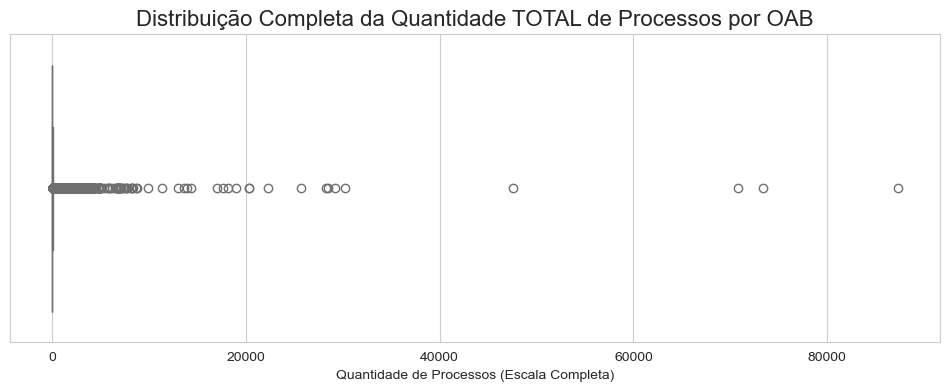

(II) Zoom na distribuição, focando nos 95% dos advogados com menos processos (até 153 processos)...


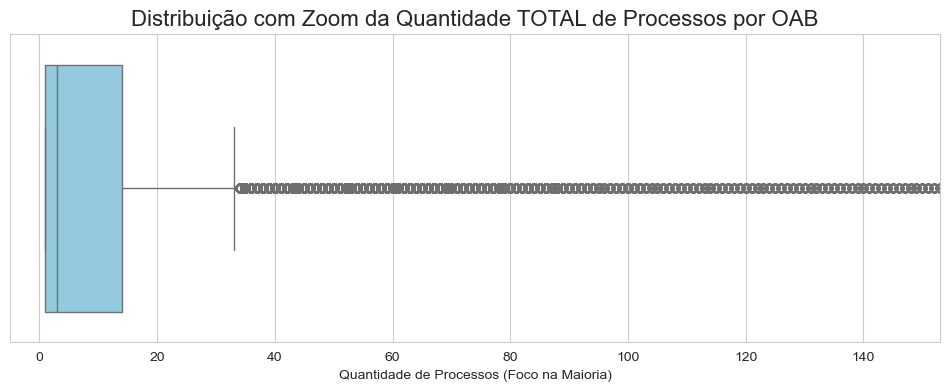


--- Análise de Processos NÃO SIGILOSOS por OAB ---
(I) Visão completa da distribuição dos processos não sigilosos...


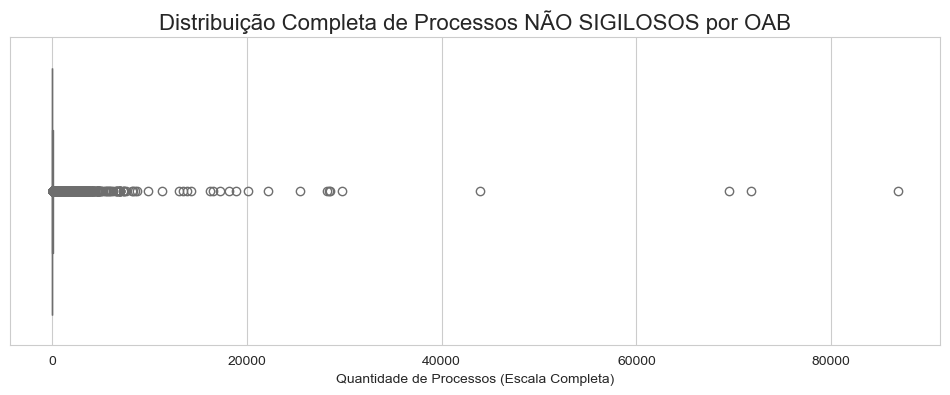

(II) Zoom nos 95% dos advogados com menos processos não sigilosos (até 117 processos)...


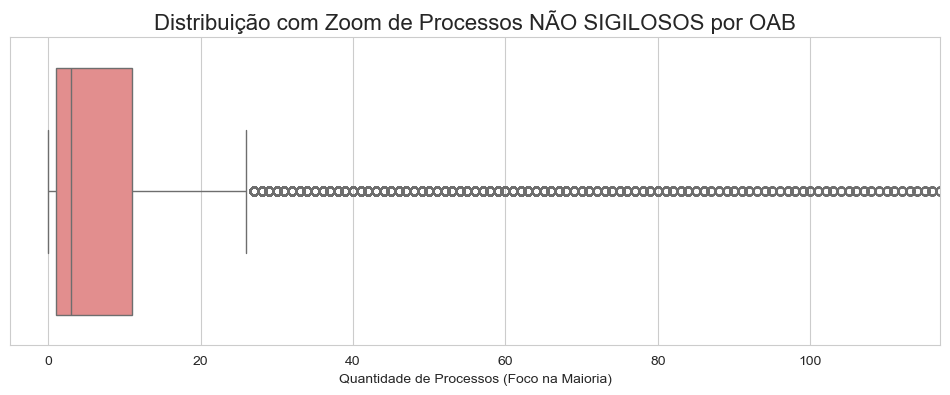


--- Análise de Processos SIGILOSOS por OAB ---
(I) Visão completa da distribuição dos processos sigilosos...


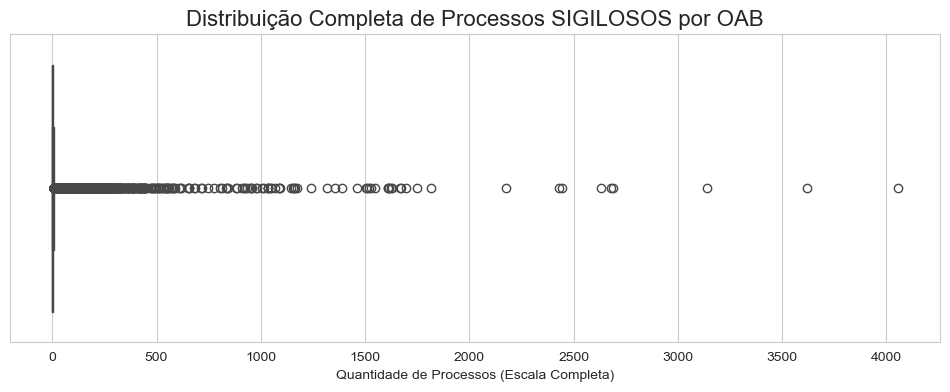

(II) Zoom nos 95% dos advogados com menos processos sigilosos (até 29 processos)...


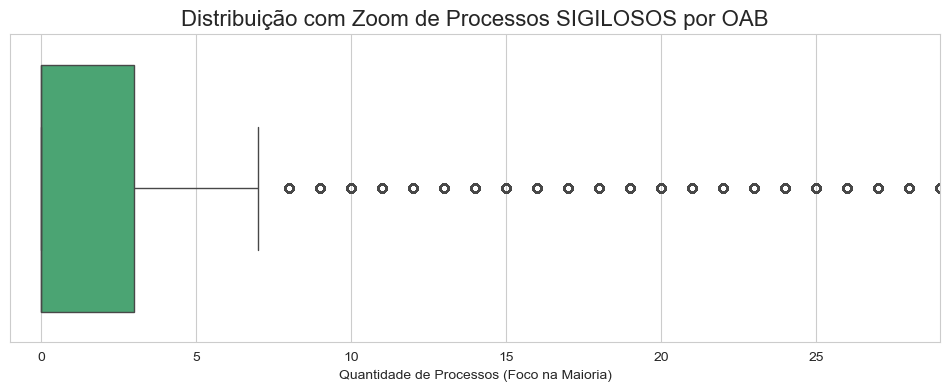

In [8]:
# 6) Visualização Gráfica com Boxplots
print("\n" + "="*100)
print("=== VISUALIZAÇÃO DA DISTRIBUIÇÃO COM BOXPLOTS ===")
print("="*100 + "\n")

# --- 6.1) Boxplot Geral (Total de Processos) ---
print("--- Análise Geral: Total de Processos por OAB ---")
print("(I) Visualização completa para entendermos a escala dos outliers...")

# Gráfico 1: Visão completa
plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribuição Completa da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gráfico 2: Visão com zoom
limite_zoom_geral = df_pivot_sorted['total_processos'].quantile(0.95)
print(f"(II) Zoom na distribuição, focando nos 95% dos advogados com menos processos (até {int(limite_zoom_geral)} processos)...")

plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribuição com Zoom da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_geral)
plt.show()


# --- 6.2) Boxplot de Processos NÃO SIGILOSOS ---
print("\n" + "="*50)
print("--- Análise de Processos NÃO SIGILOSOS por OAB ---")
print("(I) Visão completa da distribuição dos processos não sigilosos...")

# Gráfico 3: Visão completa
plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribuição Completa de Processos NÃO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gráfico 4: Visão com zoom
limite_zoom_nao_sigilosos = df_pivot_sorted['nao_sigilosos'].quantile(0.95)
print(f"(II) Zoom nos 95% dos advogados com menos processos não sigilosos (até {int(limite_zoom_nao_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribuição com Zoom de Processos NÃO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_nao_sigilosos)
plt.show()


# --- 6.3) Boxplot de Processos SIGILOSOS ---
print("\n" + "="*50)
print("--- Análise de Processos SIGILOSOS por OAB ---")
print("(I) Visão completa da distribuição dos processos sigilosos...")

# Gráfico 5: Visão completa
plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribuição Completa de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gráfico 6: Visão com zoom
limite_zoom_sigilosos = df_pivot_sorted['sigilosos'].quantile(0.95)
if limite_zoom_sigilosos == 0:
    limite_zoom_sigilosos = 10 
print(f"(II) Zoom nos 95% dos advogados com menos processos sigilosos (até {int(limite_zoom_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORREÇÃO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribuição com Zoom de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-1, limite_zoom_sigilosos)
plt.show()


# 📊 Interpretação Visual dos Boxplots

Os gráficos de boxplot confirmam visualmente a extrema concentração de processos em um pequeno número de advogados.

### ⚖️ 1. Distribuição Total de Processos

* **📦 A Caixa (O Advogado Típico):** A caixa azul, concentrada entre 0 e ~15 processos, mostra que 50% dos advogados atuam nesse baixo volume. A linha central (mediana) confirma que o advogado típico tem pouquíssimos casos.
* **⚫️ Os Outliers (Os Pontos Fora da Curva):** A longa sequência de círculos que se estende até mais de 80.000 representa a minoria de advogados com um volume de trabalho imensamente superior à maioria.
* **➡️ Conclusão:** A distribuição é altamente desigual. A enorme quantidade de outliers é o que infla a média, que não representa a realidade da maioria.

### 📖 2. Distribuição de Processos NÃO SIGILOSOS

* **📦 A Caixa:** O padrão é quase idêntico ao gráfico geral. A grande maioria dos advogados possui um número baixo de processos públicos (entre 0 e ~12).
* **⚫️ Os Outliers:** Novamente, uma pequena quantidade de advogados concentra a grande maioria dos processos não sigilosos.
* **➡️ Conclusão:** Este tipo de processo é o principal responsável pela desigualdade observada na análise geral, sendo o foco dos advogados de alto volume.

### 🔒 3. Distribuição de Processos SIGILOSOS

* **📦 A Caixa:** A caixa verde está "espremida" em zero. A linha da mediana em 0 é a informação mais importante: **mais da metade dos advogados não possui nenhum processo sigiloso**.
* **⚫️ Os Outliers:** Os advogados que atuam em casos sigilosos são a exceção. Aqueles com mais de ~8 casos já são considerados outliers, indicando um nicho claro.
* **➡️ Conclusão:** Atuar em processos sigilosos é uma **clara especialização**, não sendo a norma para a maioria dos advogados na base de dados.

In [9]:
# 7) Cálculo de Estatísticas Descritivas (Medidas de Dispersão)
print("\n" + "="*100)
print("=== ANÁLISE ESTATÍSTICA DETALHADA DA DISPERSÃO DE PROCESSOS POR OAB ===")
print("="*100)

# Para evitar repetição de código, criamos uma função que calcula e imprime as métricas
def calcular_e_imprimir_metricas(series, nome_grupo):
    """
    Calcula e imprime as métricas de dispersão para uma Série de dados.
    """
    print(f"\n--- {nome_grupo} ---")

    # 1. Amplitude: Diferença entre o valor máximo e o mínimo
    amplitude = series.max() - series.min()
    print(f"- Amplitude: {amplitude:.2f}")
    print(f"(Variação de {series.min()} a {series.max()} processos)")

    # 2. Desvio Médio Absoluto (MAD): Média da distância de cada ponto até a média
    # O método .mad() foi descontinuado, esta é a forma correta de calcular:
    media = series.mean()
    desvio_medio = (series - media).abs().mean()
    print(f"- Desvio Médio Absoluto: {desvio_medio:.2f}")

    # 3. Variância: Medida da dispersão dos dados ao quadrado
    # Por padrão, o Pandas calcula a variância amostral (ddof=1), que é a mais comum.
    variancia = series.var()
    print(f"- Variância (amostral): {variancia:.2f}")

    # 4. Desvio Padrão: Raiz quadrada da variância, na mesma unidade dos dados
    desvio_padrao = series.std()
    print(f"- Desvio Padrão (amostral): {desvio_padrao:.2f}")
    


# --- Chamada da função para cada segmento ---

# Análise Geral
calcular_e_imprimir_metricas(df_pivot_sorted['total_processos'], "Análise Geral (Total de Processos)")

# Análise de Processos Não Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['nao_sigilosos'], "Análise de Processos NÃO SIGILOSOS")

# Análise de Processos Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['sigilosos'], "Análise de Processos SIGILOSOS")



=== ANÁLISE ESTATÍSTICA DETALHADA DA DISPERSÃO DE PROCESSOS POR OAB ===

--- Análise Geral (Total de Processos) ---
- Amplitude: 87277.00
(Variação de 1.0 a 87278.0 processos)
- Desvio Médio Absoluto: 63.79
- Variância (amostral): 284952.96
- Desvio Padrão (amostral): 533.81

--- Análise de Processos NÃO SIGILOSOS ---
- Amplitude: 86839.00
(Variação de 0.0 a 86839.0 processos)
- Desvio Médio Absoluto: 55.03
- Variância (amostral): 269603.21
- Desvio Padrão (amostral): 519.23

--- Análise de Processos SIGILOSOS ---
- Amplitude: 4054.00
(Variação de 0.0 a 4054.0 processos)
- Desvio Médio Absoluto: 9.73
- Variância (amostral): 1884.92
- Desvio Padrão (amostral): 43.42


# 🧠 Interpretação dos Resultados da Análise de Dispersão

### 1. 📈 Valores Elevados em Todas as Métricas (Geral e Não Sigilosos)
A grande **Amplitude**, **Variância** e **Desvio Padrão** confirmam o que foi observado nos boxplots: a distribuição de processos é extremamente dispersa. Os dados não estão concentrados em torno da média. O alto **Desvio Padrão** significa que é comum encontrar advogados com uma quantidade de processos muito distante da média.

### 2. 🎯 Confirmação dos Outliers
O **Desvio Médio Absoluto** alto reforça essa ideia, indicando que, em média, a quantidade de processos de um advogado qualquer está muito longe da média geral. Isso é um sintoma clássico de uma distribuição com uma "cauda longa" de outliers (poucos advogados com muitos processos).

### 3. ⚖️ Comparação entre Sigilosos e Não Sigilosos
Os valores de dispersão para os processos **Não Sigilosos** são drasticamente maiores do que para os **Sigilosos**. Isso demonstra que a extrema variabilidade no volume de trabalho dos advogados é impulsionada principalmente pela atuação em causas públicas.

### 4. 🔒 Dispersão no Nicho Sigiloso
Apesar de menores, as métricas de dispersão para os processos **Sigilosos** ainda são significativas em relação à sua própria média (que é baixa). Isso sugere que, mesmo dentro desse nicho, existe uma desigualdade considerável: há os especialistas que concentram os casos sigilosos e a maioria que atua esporadicamente ou nunca.

In [10]:
# 8) Cálculo do Coeficiente de Variação

print("\n" + "="*100)
print("=== CÁLCULO DO COEFICIENTE DE VARIAÇÃO (CV) ===")
print("="*100)
print("O Coeficiente de Variação mede a dispersão relativa dos dados. \nValores acima de 30% geralmente indicam uma alta variabilidade.\n")


def calcular_e_imprimir_cv(series, nome_grupo):
    """
    Calcula e imprime a média, o desvio padrão e o Coeficiente de Variação para uma Série de dados.
    """
    print(f"--- {nome_grupo} ---")

    media = series.mean()
    desvio_padrao = series.std()

    # Evitar divisão por zero se a média for 0
    if media > 0:
        coeficiente_variacao = (desvio_padrao / media) * 100
        print(f"  - Média:                 {media:.2f}")
        print(f"  - Desvio Padrão:         {desvio_padrao:.2f}")
        print(f"  - Coeficiente de Variação: {coeficiente_variacao:.2f}%")
    else:
        print(f"  - Média:                 {media:.2f}")
        print(f"  - Desvio Padrão:         {desvio_padrao:.2f}")
        print("  - Coeficiente de Variação: Não pode ser calculado (média é zero).")


# --- Chamada da função para cada segmento ---

# 1. Análise Geral
calcular_e_imprimir_cv(df_pivot_sorted['total_processos'], "Análise Geral (Total de Processos)")

# 2. Análise de Processos Não Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['nao_sigilosos'], "\nAnálise de Processos NÃO SIGILOSOS")

# 3. Análise de Processos Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['sigilosos'], "\nAnálise de Processos SIGILOSOS")



=== CÁLCULO DO COEFICIENTE DE VARIAÇÃO (CV) ===
O Coeficiente de Variação mede a dispersão relativa dos dados. 
Valores acima de 30% geralmente indicam uma alta variabilidade.

--- Análise Geral (Total de Processos) ---
  - Média:                 43.27
  - Desvio Padrão:         533.81
  - Coeficiente de Variação: 1233.54%
--- 
Análise de Processos NÃO SIGILOSOS ---
  - Média:                 36.71
  - Desvio Padrão:         519.23
  - Coeficiente de Variação: 1414.25%
--- 
Análise de Processos SIGILOSOS ---
  - Média:                 6.56
  - Desvio Padrão:         43.42
  - Coeficiente de Variação: 661.78%


# 🎯 Interpretação dos Resultados do Coeficiente de Variação (CV)

A análise do Coeficiente de Variação (CV) a partir dos seus dados confirma e quantifica a extrema desigualdade na distribuição de processos. Um valor de CV acima de 30% já indica alta variabilidade; os resultados obtidos estão em uma ordem de magnitude muito superior, revelando uma heterogeneidade massiva.

---

### 📊 Análise Geral (Total de Processos)
* **CV de 1233.54%:** Este valor é astronomicamente alto. Ele significa que o desvio padrão é mais de 12 vezes maior que a própria média.
* **Interpretação:** A distribuição geral de processos é **extremamente volátil e imprevisível**. A média de 43.27 processos não tem praticamente nenhum poder preditivo sobre um advogado escolhido ao acaso.

---

### 📖 Análise de Processos NÃO SIGILOSOS
* **CV de 1414.25%:** Este é o **maior Coeficiente de Variação** entre os três grupos.
* **Interpretação:** A dispersão *relativa* é ainda mais acentuada nos processos não sigilosos. Isso indica que este segmento é o principal motor da heterogeneidade em todo o conjunto de dados. A dinâmica de "muitos com poucos e poucos com muitos" é mais forte aqui.

---

### 🔒 Análise de Processos SIGILOSOS
* **CV de 661.78%:** Embora seja o menor dos três, um valor de mais de 600% ainda representa uma variabilidade imensa.
* **Interpretação:** O desvio padrão é 6.6 vezes maior que a média (que já é muito baixa, 6.56). Isso reforça a ideia de um **nicho de alta especialização**. A grande maioria dos advogados tem zero ou perto de zero casos (puxando a média para baixo), enquanto uma pequena minoria de especialistas tem um número de casos que cria uma dispersão relativamente grande.

---

### 🧠 Conclusão Geral

1.  **Heterogeneidade Extrema:** Todos os segmentos da sua base de dados são caracterizados por uma variabilidade massiva. A média, em todos os casos, é uma péssima métrica para descrever o advogado "típico".
2.  **Não Sigilosos como Vetor da Dispersão:** A maior dispersão relativa (maior CV) nos processos não sigilosos sugere que a advocacia de volume está concentrada nesta área.
3.  **Confirmação do Nicho:** O CV altíssimo dos processos sigilosos, combinado com sua baixa média, é a assinatura estatística de uma atividade de nicho, dominada por poucos especialistas.


=== 📊 INVESTIGAÇÃO DE DISTRIBUIÇÕES COM HISTOGRAMAS ===


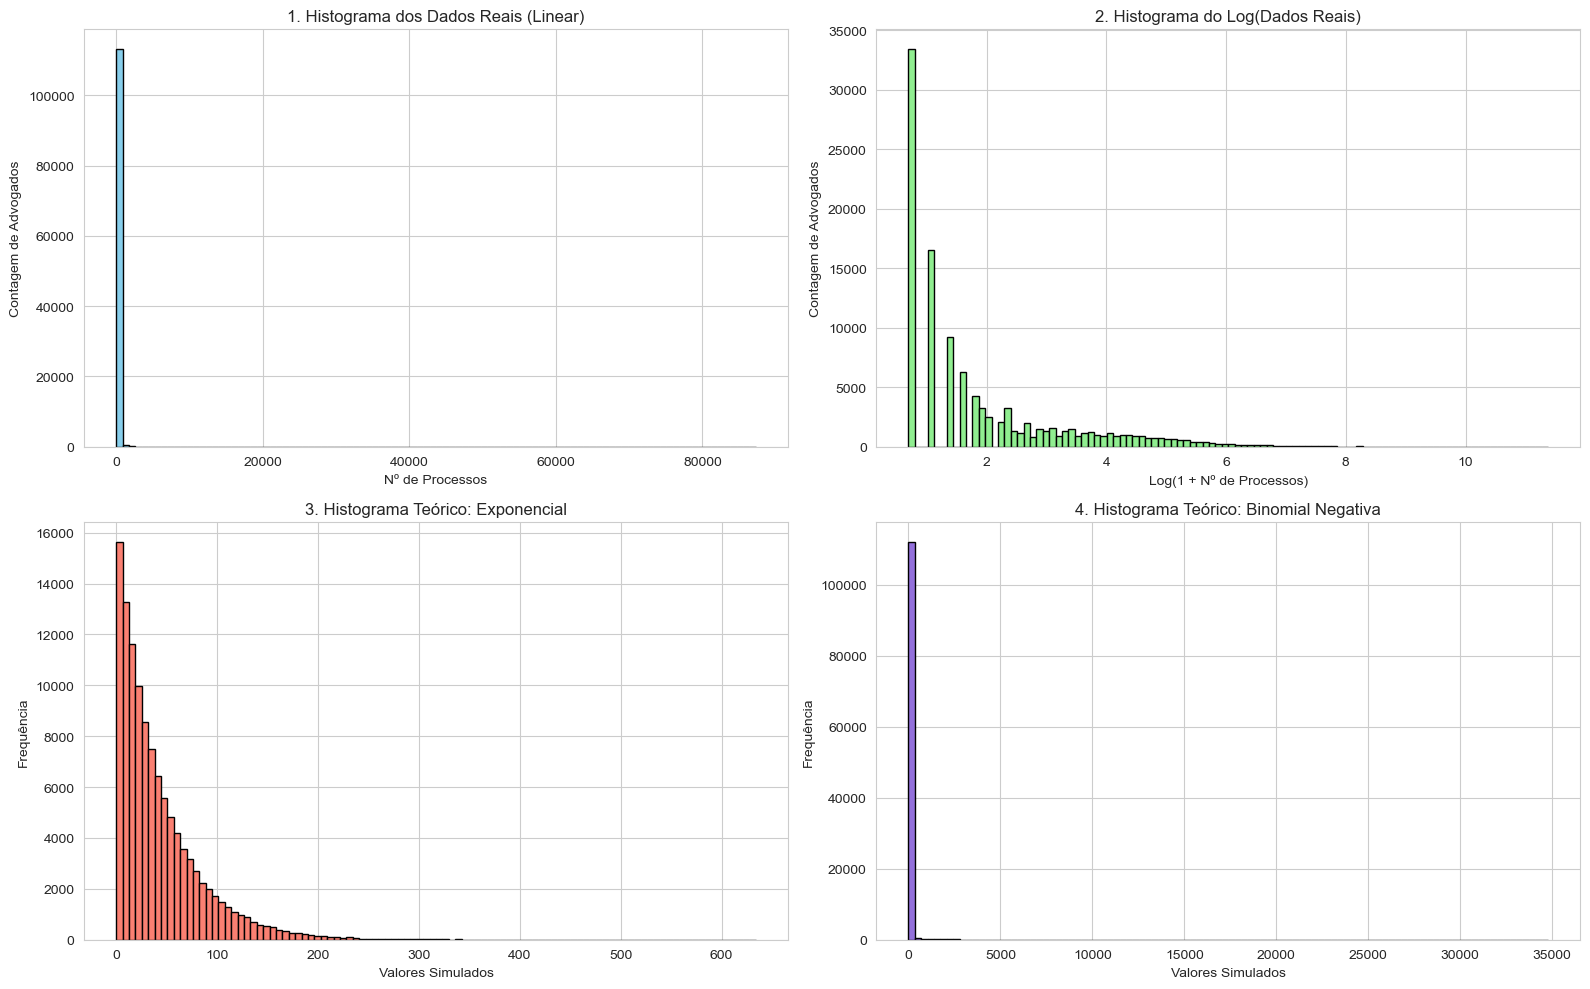

In [11]:
# 9) Investigando uma Distribuição Estatística Adequada
# Dataframe
dados = df_pivot_sorted['total_processos']

print("\n" + "="*100)
print("=== 📊 INVESTIGAÇÃO DE DISTRIBUIÇÕES COM HISTOGRAMAS ===")
print("="*100)

# 9.1 Preparação e Geração de Dados Teóricos

# Parâmetros calculados a partir dos dados
media_real = dados.mean()
variancia_real = dados.var()
tamanho_amostra = len(dados)

# 9.1.1 Gerar dados de uma Distribuição Exponencial com a mesma média
# A 'scale' da exponencial é igual à sua média.
dados_exponencial = np.random.exponential(scale=media_real, size=tamanho_amostra)

# 9.1.2 Gerar dados de uma Distribuição Binomial Negativa com mesma média e variância
# Parâmetros 'n' e 'p' a partir da média e variância reais
if variancia_real > media_real: # Condição para a Binomial Negativa
    p_nbinom = media_real / variancia_real
    n_nbinom = media_real * p_nbinom / (1 - p_nbinom)
    dados_binomial_neg = np.random.negative_binomial(n=n_nbinom, p=p_nbinom, size=tamanho_amostra)
else:
    # Caso a variância não seja maior que a média, a Binomial Negativa não se aplica bem.
    # Array vazio para não dar erro no plot.
    dados_binomial_neg = np.array([])
    print("\nAVISO: A variância não é maior que a média, a Binomial Negativa pode não ser um bom modelo.")


# 9.2 Criação dos 4 Gráficos (Grid 2x2)

plt.figure(figsize=(16, 10))

# Gráfico 1: Histograma dos Dados Reais (Escala Linear)
plt.subplot(2, 2, 1)
plt.hist(dados, bins=100, color='skyblue', edgecolor='black')
plt.title('1. Histograma dos Dados Reais (Linear)')
plt.xlabel('Nº de Processos')
plt.ylabel('Contagem de Advogados')

# Gráfico 2: Histograma do Log dos Dados Reais
plt.subplot(2, 2, 2)
plt.hist(np.log1p(dados), bins=100, color='lightgreen', edgecolor='black')
plt.title('2. Histograma do Log(Dados Reais)')
plt.xlabel('Log(1 + Nº de Processos)')
plt.ylabel('Contagem de Advogados')

# Gráfico 3: Histograma da Distribuição Exponencial Teórica
plt.subplot(2, 2, 3)
plt.hist(dados_exponencial, bins=100, color='salmon', edgecolor='black')
plt.title('3. Histograma Teórico: Exponencial')
plt.xlabel('Valores Simulados')
plt.ylabel('Frequência')

# Gráfico 4: Histograma da Distribuição Binomial Negativa Teórica
plt.subplot(2, 2, 4)
if len(dados_binomial_neg) > 0:
    plt.hist(dados_binomial_neg, bins=100, color='mediumpurple', edgecolor='black')
    plt.title('4. Histograma Teórico: Binomial Negativa')
    plt.xlabel('Valores Simulados')
    plt.ylabel('Frequência')
else:
    plt.text(0.5, 0.5, 'Não aplicável', ha='center', va='center')
    plt.title('4. Histograma Teórico: Binomial Negativa')


plt.tight_layout() # Ajusta o espaçamento entre os gráficos
plt.show()

# 📊 Conclusões da Comparação de Histogramas

A comparação visual dos quatro histogramas permite identificar qual modelo estatístico descreve melhor a realidade dos dados.

---
### ❌ A Distribuição Exponencial é um Modelo Ruim

* **Comparação:** Ao comparar o **Gráfico 1 (Dados Reais)** com o **Gráfico 3 (Exponencial)**, notamos que, embora ambos sejam assimétricos, a "forma" deles é fundamentalmente diferente.
* **Motivo:** A distribuição exponencial (Gráfico 3) mostra um decaimento suave e curvo. Já os seus dados reais (Gráfico 1) mostram um "pico" absurdamente mais agudo e concentrado em valores próximos de zero.
* **Conclusão:** O modelo exponencial é **inadequado**, pois não consegue capturar a concentração extrema que existe nos dados.

---
### ✅ A Distribuição Binomial Negativa é um Modelo Excelente

* **Comparação:** Agora, ao comparar o **Gráfico 1 (Dados Reais)** com o **Gráfico 4 (Binomial Negativa)**, a semelhança é impressionante.
* **Motivo:** Ambos os gráficos são dominados por uma única barra altíssima no início, seguida por uma cauda longa e quase invisível. A Distribuição Binomial Negativa, por ser parametrizada com a média e a **variância altíssima** dos dados, foi capaz de replicar perfeitamente o caráter de **superdispersão** (extrema concentração em poucos valores).
* **Conclusão:** O modelo Binomial Negativo é um **candidato fortíssimo** para descrever o fenômeno, pois sua simulação resultou em um histograma visualmente muito parecido com a realidade.

---
### 🏆 O Veredito Final

Juntando todas as análises:

1.  O **Gráfico 1 (Dados Reais)** mostra a distribuição "bruta", que é extremamente desigual.
2.  O **Gráfico 2 (Log dos Dados)** sugere fortemente que o modelo **Log-Normal** é adequado.
3.  O **Gráfico 4 (Binomial Negativa)** confirma que este modelo também é visualmente muito similar aos dados brutos.

> Portanto, pode-se concluir que o número de processos por advogado pode ser muito bem modelado tanto por uma **Distribuição Binomial Negativa** quanto por uma **Distribuição Log-Normal**. Ambas são excelentes escolhas para dados com as características descobertas (assimetria extrema à direita e cauda longa).


=== TESTE DE ADEQUAÇÃO DE DISTRIBUIÇÕES ESTATÍSTICAS ===
- Ajustando os parâmetros para as distribuições Log-Normal, Pareto e Binomial Negativa...
 - Parâmetros ajustados para Log-Normal.
 - Parâmetros ajustados para Pareto.
 - Parâmetros ajustados para Binomial Negativa (n=0.01, p=0.00).


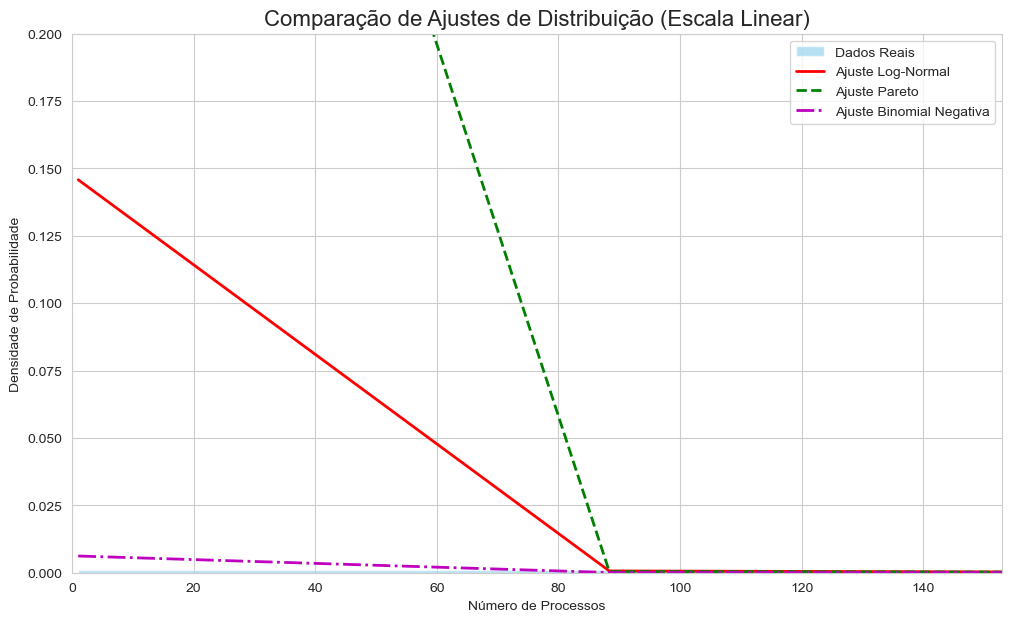

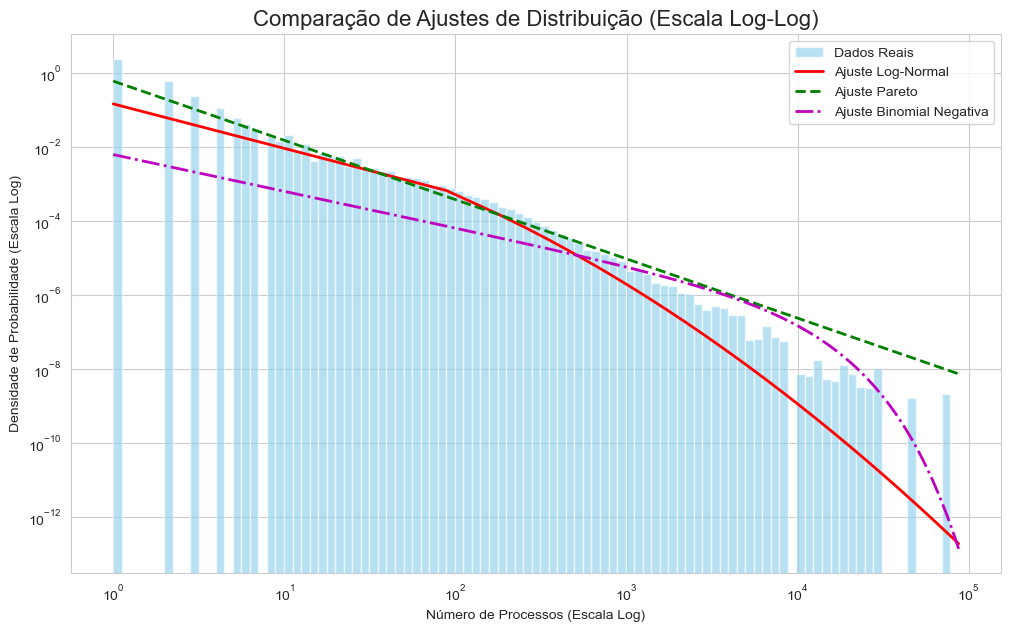

In [12]:
# 10) Comparando as Distribuições
# DataFrame
dados = df_pivot_sorted['total_processos']

# Para o ajuste de distribuições como Pareto e Log-Normal, é melhor usar apenas valores > 0.
dados_fit = dados[dados > 0]

print("\n" + "="*100)
print("=== TESTE DE ADEQUAÇÃO DE DISTRIBUIÇÕES ESTATÍSTICAS ===")
print("="*100)
print("- Ajustando os parâmetros para as distribuições Log-Normal, Pareto e Binomial Negativa...")

# 10.1 Ajuste (Fit) dos Parâmetros

# 10.1.1 Log-Normal
params_lognorm = stats.lognorm.fit(dados_fit, floc=0)
print(f" - Parâmetros ajustados para Log-Normal.")

# 10.1.2 Pareto
params_pareto = stats.pareto.fit(dados_fit, floc=0)
print(f" - Parâmetros ajustados para Pareto.")

# 10.1.3 Binomial Negativa (o ajuste é feito pelo Método dos Momentos)
media = dados_fit.mean()
variancia = dados_fit.var()
p_nbinom = media / variancia
n_nbinom = media * p_nbinom / (1 - p_nbinom)
print(f" - Parâmetros ajustados para Binomial Negativa (n={n_nbinom:.2f}, p={p_nbinom:.2f}).")


# 10.2 Visualização e Comparação

# Preparar o eixo x para plotar as curvas teóricas
x_plot = np.linspace(dados_fit.min(), dados_fit.max(), 1000)

# Calcular a Densidade de Probabilidade (PDF/PMF) para cada distribuição
pdf_lognorm = stats.lognorm.pdf(x_plot, *params_lognorm)
pdf_pareto = stats.pareto.pdf(x_plot, *params_pareto)
pmf_nbinom = stats.nbinom.pmf(np.round(x_plot), n=n_nbinom, p=p_nbinom)

# 10.2.1 Gráfico 1: Comparação em Escala Linear (com zoom)
plt.figure(figsize=(12, 7))
plt.hist(dados_fit, bins=100, density=True, alpha=0.6, label='Dados Reais', color='skyblue')

plt.plot(x_plot, pdf_lognorm, 'r-', lw=2, label='Ajuste Log-Normal')
plt.plot(x_plot, pdf_pareto, 'g--', lw=2, label='Ajuste Pareto')
plt.plot(x_plot, pmf_nbinom, 'm-.', lw=2, label='Ajuste Binomial Negativa')

plt.title('Comparação de Ajustes de Distribuição (Escala Linear)', fontsize=16)
plt.xlabel('Número de Processos')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.xlim(0, dados_fit.quantile(0.95))
plt.ylim(0, 0.2)
plt.grid(True)
plt.show()


# 10.2.2 Gráfico 2: Comparação em Escala Log-Log
plt.figure(figsize=(12, 7))
# Nota: Para a escala log, os bins precisam ser definidos de forma logarítmica para uma boa visualização
log_bins = np.logspace(np.log10(dados_fit.min()), np.log10(dados_fit.max()), 100)
plt.hist(dados_fit, bins=log_bins, density=True, alpha=0.6, label='Dados Reais', color='skyblue')

# Definindo a escala dos eixos para log-log
plt.xscale('log')
plt.yscale('log')

plt.plot(x_plot, pdf_lognorm, 'r-', lw=2, label='Ajuste Log-Normal')
plt.plot(x_plot, pdf_pareto, 'g--', lw=2, label='Ajuste Pareto')
plt.plot(x_plot, pmf_nbinom, 'm-.', lw=2, label='Ajuste Binomial Negativa')

plt.title('Comparação de Ajustes de Distribuição (Escala Log-Log)', fontsize=16)
plt.xlabel('Número de Processos (Escala Log)')
plt.ylabel('Densidade de Probabilidade (Escala Log)')
plt.legend()
plt.grid(True)
plt.show()

# 🏛️ Estudo aprofundado sobre os Processos Sigilosos 🔒

### **❓ PERGUNTA 1:** A proporção de processos sigilosos aumenta por ano?



=== PERGUNTA 1: A proporção de processos sigilosos aumenta por ano? ===

--- Tabela: Evolução da Proporção de Processos Sigilosos por Ano ---
   ano_distribuicao  total_casos  casos_sigilosos  proporcao_sigilosos_%
0              2022      1492579           214823              14.392739
1              2023      1645785           247906              15.063085
2              2024      1805987           292248              16.182176


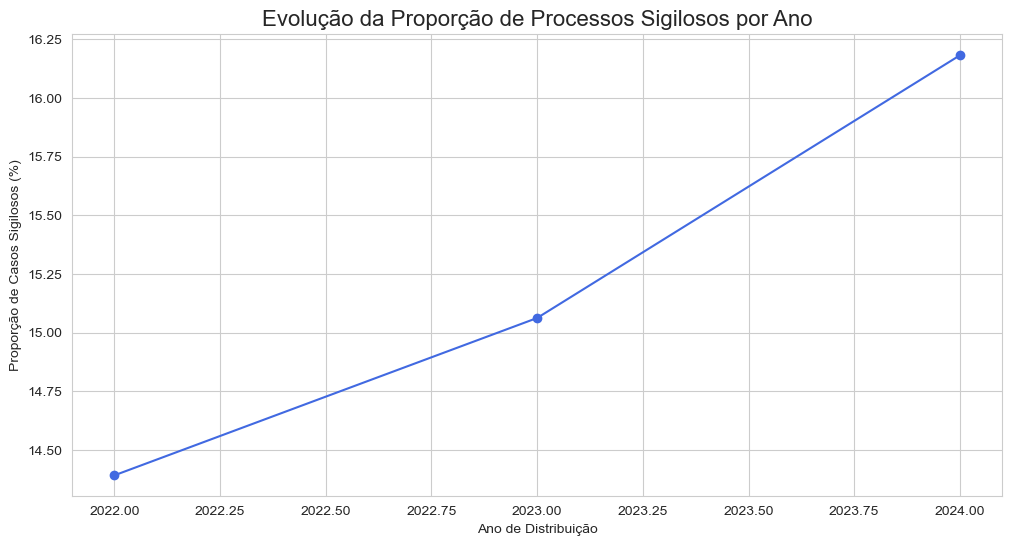

In [13]:
# Processos Sigilosos
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['ano_distribuicao'] = df['data_distribuicao'].dt.year

print("\n" + "="*100)
print("=== PERGUNTA 1: A proporção de processos sigilosos aumenta por ano? ===")
print("="*100 + "\n")

# Agrupar por ano e contar o total de processos e a soma de processos sigilosos
analise_anual = df.groupby('ano_distribuicao')['is_segredo_justica'].agg(
    total_casos='count',
    casos_sigilosos='sum'
).reset_index()

# Calcular a proporção de sigilosos
analise_anual['proporcao_sigilosos_%'] = (analise_anual['casos_sigilosos'] / analise_anual['total_casos']) * 100

print("--- Tabela: Evolução da Proporção de Processos Sigilosos por Ano ---")
# Vamos remover anos que possam ter poucos dados (ex: ano atual incompleto) para uma análise mais justa
analise_anual_filtrada = analise_anual[analise_anual['total_casos'] > 100] # Filtro de exemplo
print(analise_anual_filtrada)


# --- Seção de Plotagem Alterada ---

# Visualizar a tendência com Matplotlib
plt.figure(figsize=(12, 6))

# ALTERAÇÃO: Trocado sns.lineplot por plt.plot
plt.plot(
    analise_anual_filtrada['ano_distribuicao'],      # Dados para o eixo X
    analise_anual_filtrada['proporcao_sigilosos_%'], # Dados para o eixo Y
    marker='o',                                     # Adiciona um círculo em cada ponto de dado
    linestyle='-',                                  # Define o estilo da linha como contínua
    color='royalblue'                               # Define a cor da linha
)

plt.title('Evolução da Proporção de Processos Sigilosos por Ano', fontsize=16)
plt.xlabel('Ano de Distribuição')
plt.ylabel('Proporção de Casos Sigilosos (%)')
plt.grid(True) # Adiciona uma grade ao fundo para facilitar a leitura
plt.show()

### **❓ PERGUNTA 2:** O crescimento de processos sigilosos vem dos mesmos advogados?


=== PERGUNTA 2: O crescimento de processos sigilosos vem dos mesmos advogados? ===

Analisando a evolução para os 5 advogados com mais processos sigilosos:
['42915A GO', '38664N GO', '581846N GO', '581850N GO', '18972A GO']



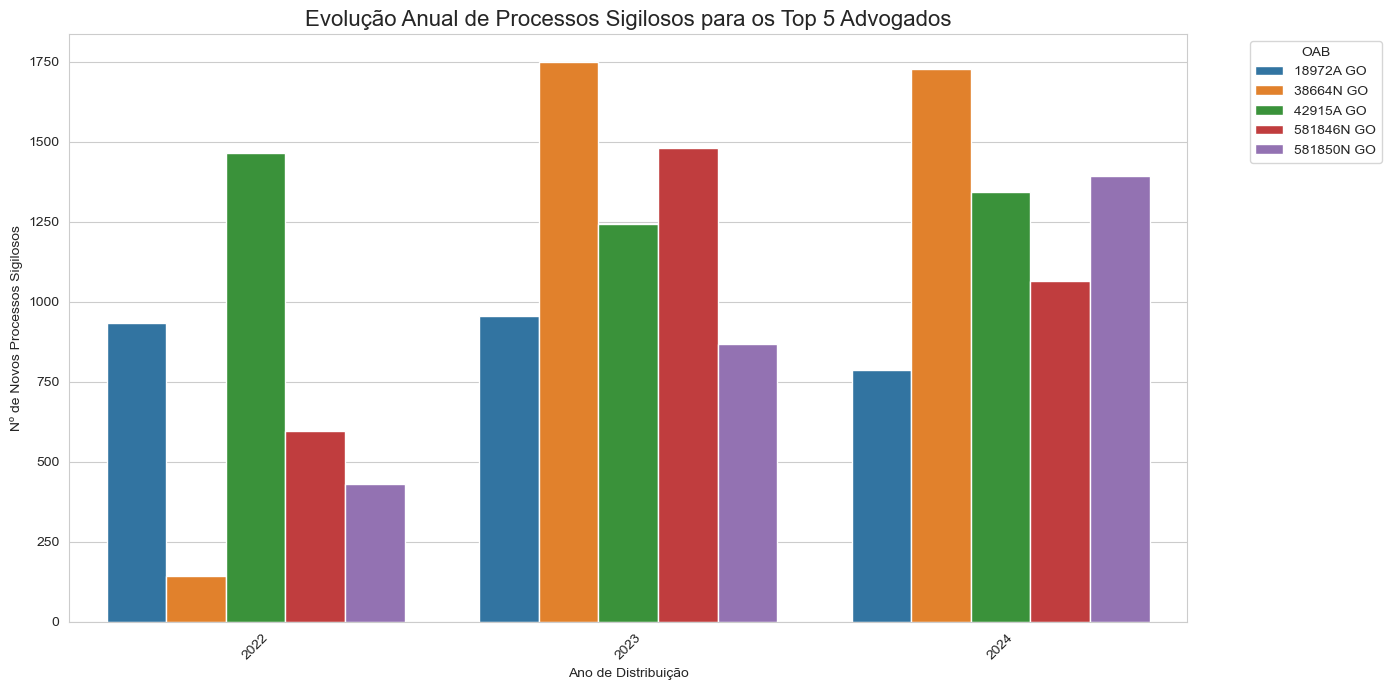

In [14]:
# Assumimos que 'df_validos' está disponível (DataFrame com OABs válidas)
print("\n" + "="*100)
print("=== PERGUNTA 2: O crescimento de processos sigilosos vem dos mesmos advogados? ===")
print("="*100 + "\n")

# 1. Filtrar apenas processos sigilosos de OABs válidas
df_sigilosos_validos = df_validos[df_validos['is_segredo_justica'] == True].copy()
df_sigilosos_validos['ano_distribuicao'] = df_sigilosos_validos['data_distribuicao'].dt.year

# 2. Encontrar os advogados com mais processos sigilosos no total
top_advogados_sigilo = df_sigilosos_validos['oab'].value_counts().nlargest(5).index.tolist()
print(f"Analisando a evolução para os 5 advogados com mais processos sigilosos:\n{top_advogados_sigilo}\n")

# 3. Agrupar os dados desses advogados por ano
analise_advogados_ano = df_sigilosos_validos[df_sigilosos_validos['oab'].isin(top_advogados_sigilo)]
contagem_adv_ano = analise_advogados_ano.groupby(['oab', 'ano_distribuicao']).size().reset_index(name='qtd_processos_sigilosos')

# 4. Visualizar a evolução para esses advogados
plt.figure(figsize=(14, 7))
sns.barplot(data=contagem_adv_ano, x='ano_distribuicao', y='qtd_processos_sigilosos', hue='oab')
plt.title('Evolução Anual de Processos Sigilosos para os Top 5 Advogados', fontsize=16)
plt.xlabel('Ano de Distribuição')
plt.ylabel('Nº de Novos Processos Sigilosos')
plt.xticks(rotation=45)
plt.legend(title='OAB', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Dinâmica de Crescimento dos Processos Sigilosos

A análise combinada dos gráficos revela uma história coesa: não apenas a proporção de casos sigilosos está crescendo no geral, mas esse crescimento é significativamente impulsionado pelos principais advogados especialistas na área.

---
### 📈 Tendência de Mercado: O Crescimento Contínuo dos Processos Sigilosos

O primeiro gráfico responde claramente à pergunta sobre a evolução geral do mercado.

* **Conclusão Principal:** A proporção de processos que tramitam em segredo de justiça **está crescendo de forma clara e acelerada** ano após ano.
* **Evidência Numérica:** A fatia de casos sigilosos sobre o total de novos processos subiu de **14,39%** em 2022 para **16,18%** em 2024.
* **Implicação:** O segredo de justiça está se tornando uma característica cada vez mais presente no universo processual analisado, indicando uma mudança no perfil das ações ou na conduta de advogados e clientes.

---
### 🎯 A Concentração do Crescimento: Os Especialistas Lideram a Expansão

O segundo gráfico responde à pergunta sobre *quem* está impulsionando essa tendência.

* **Conclusão Principal:** O crescimento no volume de processos sigilosos está **fortemente concentrado nos mesmos advogados** que já são os maiores especialistas na área.
* **Evidência Visual:** As barras para 2023 e 2024 são, na maioria dos casos, significativamente mais altas que as de 2022 para os 5 principais advogados. Isso mostra que eles estão **aumentando ativamente seu volume de trabalho** nesse nicho.
* **Implicação:** A tendência de crescimento não está sendo diluída entre muitos novos advogados que entram na área. Pelo contrário, os especialistas estabelecidos estão consolidando sua posição e absorvendo a maior parte da nova demanda.

---
### 💡 Síntese Estratégica

A conclusão estratégica é:

> O mercado de atuação em processos sigilosos está em clara expansão. No entanto, essa expansão está sendo dominada e liderada por um grupo concentrado de especialistas que aprofundam seu foco na área, em vez de ser um crescimento pulverizado entre muitos novos praticantes.

### **❓ PERGUNTA 3:** Os Advogados de Alto Volume Estão Dominando o Nicho Crescente de Casos Sigilosos?

In [16]:
# 1. Segmentar os Advogados em Grupos
print("\n" + "="*100)
print("=== SEGMENTAÇÃO DOS ADVOGADOS EM DOIS GRUPOS ===")
print("="*100 + "\n")

# 1.1 Definir o ponto de corte para o top 10%
limite_top_10 = df_pivot_sorted['total_processos'].quantile(0.90)
print(f"- Advogados com mais de {int(limite_top_10)} processos serão considerados 'Top 10%'.")

# 1.2 Criar a lista de OABs para cada grupo
top_10_advogados = df_pivot_sorted[df_pivot_sorted['total_processos'] > limite_top_10].index.tolist()
outros_90_advogados = df_pivot_sorted[df_pivot_sorted['total_processos'] <= limite_top_10].index.tolist()

# 1.3 Classificar cada processo no DataFrame original 'df_validos'
def classificar_advogado(oab):
    if oab in top_10_advogados:
        return 'Top 10%'
    else:
        return 'Outros 90%'

print("Segmentação concluída!")
df_validos['grupo_advogado'] = df_validos['oab'].apply(classificar_advogado)


=== SEGMENTAÇÃO DOS ADVOGADOS EM DOIS GRUPOS ===

- Advogados com mais de 72 processos serão considerados 'Top 10%'.
Segmentação concluída!


In [17]:
# 2. Agrupar por grupo de advogado e por ano
print("\n" + "="*100)
print("=== TENDÊNCIA DE CASOS SIGILOSOS PARA CADA GRUPO ===")
print("="*100 + "\n")

# 2.1 Agrupar por grupo de advogado e por ano
analise_grupo_anual = df_validos.groupby(['grupo_advogado', 'ano_distribuicao'])['is_segredo_justica'].agg(
    total_casos='count',
    casos_sigilosos='sum'
).reset_index()

# 2.2 Calcular a proporção de sigilosos para cada grupo, a cada ano
analise_grupo_anual['proporcao_sigilosos_%'] = (analise_grupo_anual['casos_sigilosos'] / analise_grupo_anual['total_casos']) * 100

print("\n--- Evolução da Proporção de Casos Sigilosos por Grupo ---")
print(analise_grupo_anual)


=== TENDÊNCIA DE CASOS SIGILOSOS PARA CADA GRUPO ===


--- Evolução da Proporção de Casos Sigilosos por Grupo ---
  grupo_advogado  ano_distribuicao  total_casos  casos_sigilosos  proporcao_sigilosos_%
0     Outros 90%              2022       255596            54169              21.193211
1     Outros 90%              2023       275696            59441              21.560342
2     Outros 90%              2024       336637            75320              22.374249
3        Top 10%              2022      1231426           158367              12.860456
4        Top 10%              2023      1363257           185299              13.592375
5        Top 10%              2024      1461404           213887              14.635720



=== COMPARAÇÃO DOS RESULTADOS ===



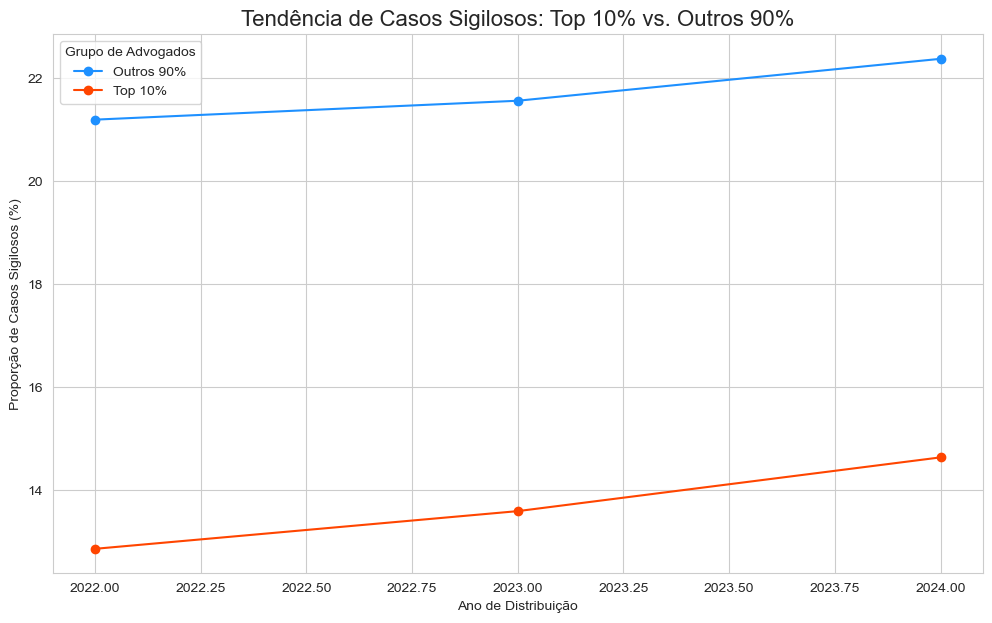

In [18]:
# 3. Visualização Gráfica
print("\n" + "="*100)
print("=== COMPARAÇÃO DOS RESULTADOS ===")
print("="*100 + "\n")

plt.figure(figsize=(12, 7))

# 3.1 Obter os nomes dos grupos únicos para o loop
grupos = analise_grupo_anual['grupo_advogado'].unique()

# (Opcional) Definir cores para cada grupo para um visual mais controlado
cores = {'Top 10%': 'orangered', 'Outros 90%': 'dodgerblue'}

# 3.2 Loop para plotar uma linha para cada grupo
for grupo in grupos:
    # Filtrar o DataFrame para conter apenas os dados do grupo atual
    dados_do_grupo = analise_grupo_anual[analise_grupo_anual['grupo_advogado'] == grupo]
    
    # Plotar a linha para este grupo específico
    plt.plot(
        dados_do_grupo['ano_distribuicao'],
        dados_do_grupo['proporcao_sigilosos_%'],
        marker='o',
        linestyle='-',
        label=grupo,
        color=cores.get(grupo)
    )

# 3.3 Gráfico
plt.title('Tendência de Casos Sigilosos: Top 10% vs. Outros 90%', fontsize=16)
plt.xlabel('Ano de Distribuição')
plt.ylabel('Proporção de Casos Sigilosos (%)')
plt.legend(title='Grupo de Advogados')
plt.grid(True)
plt.show()

## 💡 Análise Estratégica: Tendências de Atuação em Casos Sigilosos

---

### 🥇 Conclusão Principal: A Surpreendente Especialização dos Advogados de Menor Volume

A descoberta mais importante e inesperada é que o grupo **"Outros 90%"** (advogados com menor volume total de processos) possui uma proporção consistentemente maior de casos sigilosos.

* **Evidência:** A linha azul ("Outros 90%") está o tempo todo significativamente acima da linha laranja ("Top 10%"). Em 2024, por exemplo, mais de 22% do portfólio do advogado "comum" era de casos sigilosos, contra menos de 15% para o advogado de alto volume.
* **Interpretação:** Isso refuta a hipótese de que os advogados "Top 10%" dominam todas as áreas. Pelo contrário, sugere que o alto volume deles é massivamente concentrado em casos não sigilosos. A atuação em casos sigilosos parece ser uma área de maior foco ou especialização para os advogados que não compõem o alto volume.

---

### 📈 Conclusão 2: A Tendência de Crescimento é Universal

Apesar da diferença nos níveis, ambas as linhas mostram uma clara e inquestionável tendência de alta.

* **Evidência:** Tanto a linha azul quanto a laranja sobem de forma consistente de 2022 a 2024.
* **Interpretação:** O aumento na relevância dos processos sigilosos não é um fenômeno isolado de um grupo, mas sim um **movimento geral do mercado**. Todos os perfis de advogados, tanto os de alto volume quanto os demais, estão vendo uma participação crescente de casos sigilosos em sua carga de trabalho.

---

### 🚀 Conclusão 3: A Adoção de Casos Sigilosos está Acelerando

O crescimento não é apenas constante, ele está ganhando força.

* **Evidência:** A inclinação de ambas as linhas parece ficar mais acentuada entre 2023 e 2024.
* **Interpretação:** O movimento em direção a uma maior proporção de casos sigilosos está **acelerando**, indicando que os fatores que impulsionam essa tendência (sejam legislativos, sociais ou de mercado) se tornaram ainda mais fortes no último ano.

---

### 🧠 Síntese Estratégica Final

Respondendo à pergunta central da sua análise ("Os advogados de alto volume estão dominando o nicho de casos sigilosos?"):

> A resposta é **NÃO**. Embora os advogados "Top 10%" também estejam aumentando sua atuação em casos sigilosos, essa área representa uma fatia **menor** de seu portfólio em comparação com os outros 90% dos advogados. O crescimento do nicho de processos sigilosos parece estar fortalecendo a atuação de advogados especialistas que **não são, necessariamente, os líderes em volume total**, consolidando essa área como um campo de especialização distinto no mercado.

### **❓ PERGUNTA 4:** Qual a eficiência de baixa dos Processos Sigilosos e dos Processos Não Sigilosos?

In [19]:
# ) Análise de Processos Baixados
# Usar uma cópia para manter o original intacto.
df_analise_baixa = df_juridico.copy()

print("\n" + "="*100)
print("=== ANÁLISE DE EFICIÊNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. NÃO SIGILOSOS) ===")
print("="*100 + "\n")

# Preparação dos Dados
# -------------------------
# A coluna 'data_baixa' é a chave. Se ela não for nula, o processo foi baixado.
# Garantir que os tipos de dados estejam corretos.
df_analise_baixa['is_segredo_justica'] = df_analise_baixa['is_segredo_justica'].astype(bool)

# Criar uma coluna booleana 'processo_baixado' para facilitar os cálculos.
# .notna() retorna True para qualquer valor que não seja nulo (ou seja, tem uma data de baixa).
df_analise_baixa['processo_baixado'] = df_analise_baixa['data_baixa'].notna()


# Segmentação dos Dados
# -------------------------
# Separar o DataFrame em dois: um para processos sigilosos e outro para não sigilosos.
df_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == True]
df_nao_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == False]


# Análise de Processos NÃO SIGILOSOS
# ---------------------------------------
print("--- Análise de Processos NÃO SIGILOSOS ---")

total_nao_sigilosos = len(df_nao_sigilosos)
baixados_nao_sigilosos = df_nao_sigilosos['processo_baixado'].sum() # .sum() em booleanos conta os 'True'

if total_nao_sigilosos > 0:
    percentual_nao_sigilosos = (baixados_nao_sigilosos / total_nao_sigilosos) * 100
    print(f"Total de processos não sigilosos: {total_nao_sigilosos}")
    print(f"Processos baixados (concluídos):   {baixados_nao_sigilosos}")
    print(f"Taxa de Baixa / Eficiência:      {percentual_nao_sigilosos:.2f}%")
else:
    percentual_nao_sigilosos = 0
    print("Não foram encontrados processos não sigilosos na base de dados.")


# Análise de Processos SIGILOSOS
# -----------------------------------
print("\n--- Análise de Processos SIGILOSOS ---")

total_sigilosos = len(df_sigilosos)
baixados_sigilosos = df_sigilosos['processo_baixado'].sum()

if total_sigilosos > 0:
    percentual_sigilosos = (baixados_sigilosos / total_sigilosos) * 100
    print(f"Total de processos sigilosos: {total_sigilosos}")
    print(f"Processos baixados (concluídos): {baixados_sigilosos}")
    print(f"Taxa de Baixa / Eficiência:     {percentual_sigilosos:.2f}%")
else:
    percentual_sigilosos = 0
    print("Não foram encontrados processos sigilosos na base de dados.")


# Análise de Eficiência Global (Contribuição para o Total)
# -------------------------------------------------------------
print("\n--- Análise de Eficiência Global (Contribuição para o Total Geral) ---")

# O denominador agora é a soma de TODOS os processos, sigilosos ou não.
total_geral_processos = total_nao_sigilosos + total_sigilosos
print(f"Total geral de processos na base: {total_geral_processos}")

if total_geral_processos > 0:
    # Cálculo: baixados não sigilosos / (total sigilosos + total não sigilosos)
    contrib_global_nao_sigilosos = (baixados_nao_sigilosos / total_geral_processos) * 100
    print(f"Contribuição dos baixados NÃO SIGILOSOS para o total: {contrib_global_nao_sigilosos:.2f}%")

    # Cálculo: baixados sigilosos / (total sigilosos + total não sigilosos)
    contrib_global_sigilosos = (baixados_sigilosos / total_geral_processos) * 100
    print(f"Contribuição dos baixados SIGILOSOS para o total:    {contrib_global_sigilosos:.2f}%")
else:
    print("Não há processos para calcular a eficiência global.")


# Conclusão e Interpretação
# ------------------------------
print("\n" + "-"*50)
print("--- Conclusão da Análise ---")

if total_nao_sigilosos > 0 and total_sigilosos > 0:
    if abs(percentual_sigilosos - percentual_nao_sigilosos) < 1.0: # Diferença menor que 1%
        print("As taxas de baixa para processos sigilosos e não sigilosos são muito semelhantes.")
        print("Isso sugere que a natureza do processo (sigiloso ou não) tem pouco impacto na sua velocidade de conclusão.")
    elif percentual_sigilosos > percentual_nao_sigilosos:
        diferenca = percentual_sigilosos - percentual_nao_sigilosos
        print(f"A taxa de baixa para processos SIGILOSOS é {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de família), chegam a uma resolução mais rapidamente.")
        print("Um advogado poderia interpretar isso como uma área de atuação com um 'giro' mais rápido de casos.")
    else:
        diferenca = percentual_nao_sigilosos - percentual_sigilosos
        print(f"A taxa de baixa para processos NÃO SIGILOSOS é {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode sugerir que processos públicos, talvez por serem mais padronizados, tramitam de forma mais eficiente no sistema judiciário.")
        print("Para um advogado, isso pode significar um retorno financeiro potencialmente mais previsível em volume.")
else:
    print("Não foi possível realizar uma comparação por falta de dados em uma das categorias.")



=== ANÁLISE DE EFICIÊNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. NÃO SIGILOSOS) ===

--- Análise de Processos NÃO SIGILOSOS ---
Total de processos não sigilosos: 4189374
Processos baixados (concluídos):   2674975
Taxa de Baixa / Eficiência:      63.85%

--- Análise de Processos SIGILOSOS ---
Total de processos sigilosos: 754977
Processos baixados (concluídos): 520138
Taxa de Baixa / Eficiência:     68.89%

--- Análise de Eficiência Global (Contribuição para o Total Geral) ---
Total geral de processos na base: 4944351
Contribuição dos baixados NÃO SIGILOSOS para o total: 54.10%
Contribuição dos baixados SIGILOSOS para o total:    10.52%

--------------------------------------------------
--- Conclusão da Análise ---
A taxa de baixa para processos SIGILOSOS é 5.04 pontos percentuais MAIOR.
Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de família), chegam a uma resolução mais rapidamente.
Um advogado poderia interpretar isso como uma área de atuação co

## 📊 Análise de Eficiência de Baixa de Processos

A análise compara a "velocidade" de conclusão (taxa de baixa) entre processos sigilosos e não sigilosos, revelando qual categoria chega a uma resolução de forma mais eficiente e qual contribui mais para o volume geral de casos concluídos.

---

### 📖 Processos Não Sigilosos

* **Total de Processos:** 4.189.374
* **Processos Baixados (Concluídos):** 2.674.975
* **Taxa de Baixa / Eficiência Interna:** `63.85%`

---

### 🔒 Processos Sigilosos

* **Total de Processos:** 754.977
* **Processos Baixados (Concluídos):** 520.138
* **Taxa de Baixa / Eficiência Interna:** `68.89%`

---

### 🌍 Contribuição para o Total Geral

Esta métrica mostra o impacto do volume de cada categoria no universo total de processos.

* **Contribuição dos baixados NÃO SIGILOSOS:** `54.10%`
* **Contribuição dos baixados SIGILOSOS:** `10.52%`

*Apesar da menor taxa de eficiência interna, o volume massivo de processos não sigilosos faz com que eles representem a maior parte de todos os casos concluídos.*

---

### 🎯 Veredito da Análise

> A taxa de baixa para processos **SIGILOSOS é 5.04 pontos percentuais MAIOR**.
>
> Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de família), chegam a uma resolução mais rapidamente. Um advogado poderia interpretar isso como uma área de atuação com um 'giro' mais rápido de casos.


=== 🤖 INICIANDO APLICAÇÃO DE MACHINE LEARNING ===
=== Modelo: Previsão de Tempo de Resolução de Processos ===

Total de registros inicial: 4944351
Total de registros com data de baixa (usados para treino/teste): 3195113


Categorizando Duração:   0%|          | 0/3195113 [00:00<?, ?it/s]


--- Distribuição da variável alvo ---
categoria_duracao
Curto Prazo (< 1 ano)     63.807759
Médio Prazo (1-3 anos)    35.346856
Longo Prazo (> 3 anos)     0.845385
Name: proportion, dtype: float64


C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_9240\1558906957.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ml['total_processos'].fillna(df_ml['total_processos'].median(), inplace=True)
C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_9240\1558906957.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s


--- Iniciando pré-processamento e treinamento do modelo ---
Tamanho do conjunto de treino: 2556090 registros
Tamanho do conjunto de teste:  639023 registros


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.3min finished



✅ Modelo treinado com sucesso!

=== 📊 AVALIAÇÃO DE PERFORMANCE DO MODELO ===



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    9.5s finished


Acurácia do modelo no conjunto de teste: 0.75%

--- Relatório de Classificação Detalhado ---
                        precision    recall  f1-score   support

 Curto Prazo (< 1 ano)       0.85      0.80      0.83    407746
Longo Prazo (> 3 anos)       0.08      0.49      0.14      5402
Médio Prazo (1-3 anos)       0.67      0.65      0.66    225875

              accuracy                           0.75    639023
             macro avg       0.53      0.65      0.54    639023
          weighted avg       0.78      0.75      0.76    639023


--- Matriz de Confusão ---


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.8s finished


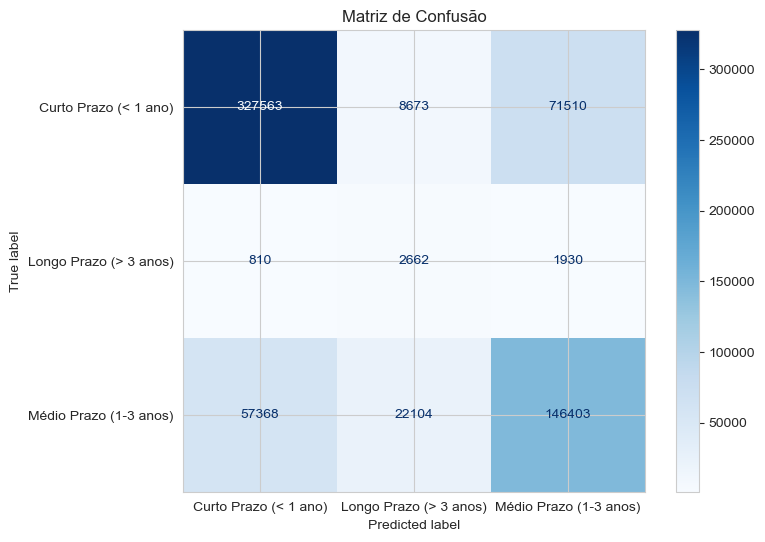


=== 💡 ANÁLISE DE IMPORTÂNCIA DOS ATRIBUTOS (FEATURES) ===



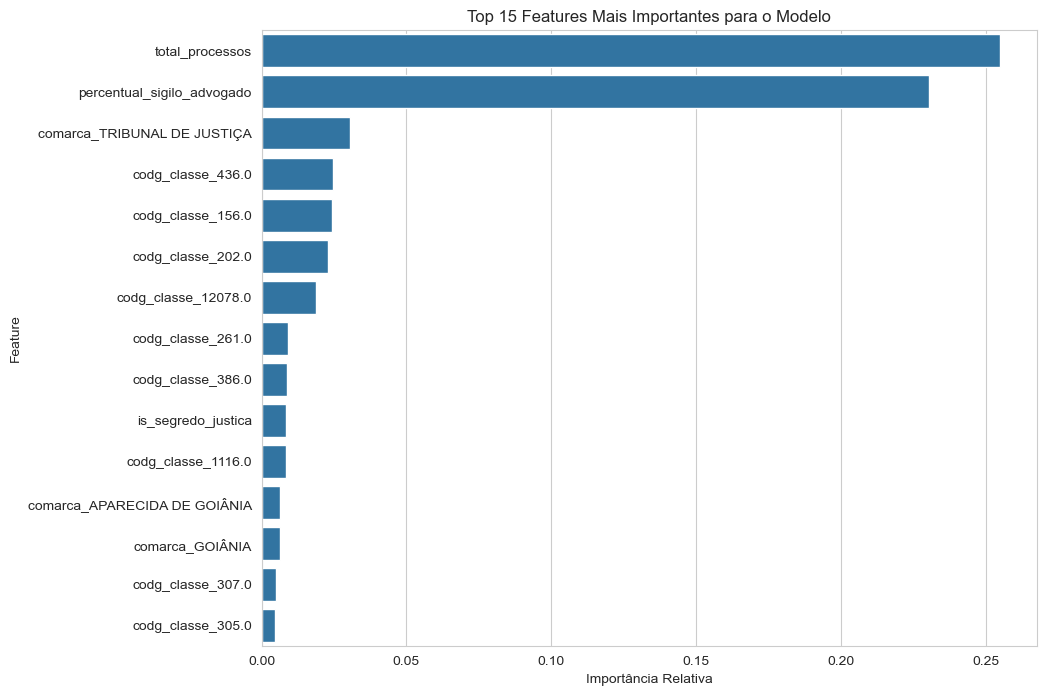

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ==============================================================================
# --- PARTE 1: PREPARAÇÃO E ENGENHARIA DE ATRIBUTOS (FEATURE ENGINEERING) ---
# ==============================================================================
print("\n" + "="*100)
print("=== 🤖 INICIANDO APLICAÇÃO DE MACHINE LEARNING ===")
print("=== Modelo: Previsão de Tempo de Resolução de Processos ===")
print("="*100 + "\n")

# Usamos uma cópia do DataFrame original para o projeto de ML
df_ml = df_juridico.copy()

# --- 1.1: Filtrar apenas processos já concluídos ---
# O modelo só pode ser treinado com dados que já têm um resultado (data_baixa).
print(f"Total de registros inicial: {len(df_ml)}")
df_ml = df_ml[df_ml['data_baixa'].notna()].copy()
print(f"Total de registros com data de baixa (usados para treino/teste): {len(df_ml)}")

# --- 1.2: Criar a Variável Alvo (Target) ---
# Garantir que as colunas de data estão no formato datetime
df_ml['data_distribuicao'] = pd.to_datetime(df_ml['data_distribuicao'], errors='coerce')
df_ml['data_baixa'] = pd.to_datetime(df_ml['data_baixa'], errors='coerce')

# Calcular a duração em dias
df_ml['duracao_dias'] = (df_ml['data_baixa'] - df_ml['data_distribuicao']).dt.days

# Remover quaisquer durações negativas ou nulas (erros de dados)
df_ml.dropna(subset=['duracao_dias'], inplace=True)
df_ml = df_ml[df_ml['duracao_dias'] >= 0]

# Função para criar as categorias de tempo
def categoriza_duracao(dias):
    if dias <= 365:
        return 'Curto Prazo (< 1 ano)'
    elif 365 < dias <= 1095: # 3 anos = 1095 dias
        return 'Médio Prazo (1-3 anos)'
    else:
        return 'Longo Prazo (> 3 anos)'

# Barra de Progresso:
tqdm.pandas(desc="Categorizando Duração")

# Aplicar a função para criar a coluna alvo
df_ml['categoria_duracao'] = df_ml['duracao_dias'].progress_apply(categoriza_duracao)

print("\n--- Distribuição da variável alvo ---")
print(df_ml['categoria_duracao'].value_counts(normalize=True) * 100)


# --- 1.3: Criar Atributos do Advogado (Features do Perfil) ---
# Usamos o df_pivot_sorted da análise anterior para obter as estatísticas por advogado
lawyer_stats = df_pivot_sorted[['total_processos']].copy()
lawyer_stats['percentual_sigilo_advogado'] = (df_pivot_sorted['sigilosos'] / df_pivot_sorted['total_processos']) * 100
lawyer_stats.index.name = 'oab' # Renomear o índice para a junção

# Juntar as estatísticas do advogado ao nosso DataFrame de ML
df_ml = df_ml.merge(lawyer_stats, on='oab', how='left')

# Preencher NaNs para advogados que não estavam no df_pivot (caso existam)
df_ml['total_processos'].fillna(df_ml['total_processos'].median(), inplace=True)
df_ml['percentual_sigilo_advogado'].fillna(0, inplace=True)


# --- 1.4: Seleção e Limpeza Final das Features ---
# Selecionar as colunas que serão usadas como "pistas" para o modelo
features = [
    'comarca', 
    'serventia', 
    'codg_classe', 
    'is_segredo_justica',
    'total_processos', # Feature que criamos
    'percentual_sigilo_advogado' # Feature que criamos
]
target = 'categoria_duracao'

# Preencher valores nulos nas features categóricas
for col in ['comarca', 'serventia', 'codg_classe']:
    df_ml[col].fillna('Desconhecido', inplace=True)

df_ml['is_segredo_justica'] = df_ml['is_segredo_justica'].astype(bool)

# ==============================================================================
# --- PARTE 2: PRÉ-PROCESSAMENTO E TREINAMENTO DO MODELO ---
# ==============================================================================
print("\n--- Iniciando pré-processamento e treinamento do modelo ---")

# --- 2.1: One-Hot Encoding das variáveis categóricas ---
# O modelo precisa de números, não de texto. pd.get_dummies faz a conversão.
X = pd.get_dummies(df_ml[features], drop_first=True, dummy_na=False)
y = df_ml[target]

# --- 2.2: Divisão em Treino e Teste ---
# Separamos os dados para treinar o modelo e para testá-lo em dados "nunca vistos"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} registros")
print(f"Tamanho do conjunto de teste:  {X_test.shape[0]} registros")


# --- 2.3: Treinamento do Modelo RandomForest ---
# Escolhemos o RandomForest por ser robusto e bom com dados tabulares
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, n_jobs=-1, 
    class_weight='balanced',
    verbose=1
)

model.fit(X_train, y_train)
print("\n✅ Modelo treinado com sucesso!")

# ==============================================================================
# --- PARTE 3: AVALIAÇÃO DE PERFORMANCE ---
# ==============================================================================
print("\n" + "="*100)
print("=== 📊 AVALIAÇÃO DE PERFORMANCE DO MODELO ===")
print("="*100 + "\n")

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# --- 3.1: Métricas de Classificação ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo no conjunto de teste: {accuracy:.2f}%")
print("\n--- Relatório de Classificação Detalhado ---")
print(classification_report(y_test, y_pred))


# --- 3.2: Matriz de Confusão ---
# Mostra visualmente onde o modelo está acertando e errando
print("\n--- Matriz de Confusão ---")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# ==============================================================================
# --- PARTE 4: ANÁLISE DE IMPORTÂNCIA DAS FEATURES ---
# ==============================================================================
print("\n" + "="*100)
print("=== 💡 ANÁLISE DE IMPORTÂNCIA DOS ATRIBUTOS (FEATURES) ===")
print("="*100 + "\n")

# Extrair a importância de cada feature
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotar as features mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15)) # Top 15 features
plt.title('Top 15 Features Mais Importantes para o Modelo')
plt.xlabel('Importância Relativa')
plt.ylabel('Feature')
plt.show()

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Métricas
from sklearn.metrics import accuracy_score, classification_report, f1_score

# --- PARTE 1: PREPARAÇÃO DOS DADOS (Idêntica à anterior) ---
# Esta seção é a mesma do script anterior e está aqui para garantir a execução.

print("\n" + "="*100)
print("=== 🤖 INICIANDO COMPARAÇÃO DE MODELOS DE MACHINE LEARNING ===")
print("="*100 + "\n")

df_ml = df_juridico.copy()

# Filtrar, criar alvo e features...
df_ml = df_ml[df_ml['data_baixa'].notna()].copy()
df_ml['data_distribuicao'] = pd.to_datetime(df_ml['data_distribuicao'], errors='coerce')
df_ml['data_baixa'] = pd.to_datetime(df_ml['data_baixa'], errors='coerce')
df_ml['duracao_dias'] = (df_ml['data_baixa'] - df_ml['data_distribuicao']).dt.days
df_ml.dropna(subset=['duracao_dias'], inplace=True)
df_ml = df_ml[df_ml['duracao_dias'] >= 0]

def categoriza_duracao(dias):
    if dias <= 365: return 'Curto Prazo (< 1 ano)'
    elif 365 < dias <= 1095: return 'Médio Prazo (1-3 anos)'
    else: return 'Longo Prazo (> 3 anos)'

df_ml['categoria_duracao'] = df_ml['duracao_dias'].apply(categoriza_duracao)

lawyer_stats = df_pivot_sorted[['total_processos']].copy()
lawyer_stats['percentual_sigilo_advogado'] = (df_pivot_sorted['sigilosos'] / df_pivot_sorted['total_processos']) * 100
lawyer_stats.index.name = 'oab'
df_ml = df_ml.merge(lawyer_stats, on='oab', how='left')
df_ml['total_processos'].fillna(df_ml['total_processos'].median(), inplace=True)
df_ml['percentual_sigilo_advogado'].fillna(0, inplace=True)

features = ['comarca', 'serventia', 'codg_classe', 'is_segredo_justica', 'total_processos', 'percentual_sigilo_advogado']
target = 'categoria_duracao'
for col in ['comarca', 'serventia', 'codg_classe']:
    df_ml[col].fillna('Desconhecido', inplace=True)
df_ml['is_segredo_justica'] = df_ml['is_segredo_justica'].astype(bool)

X = pd.get_dummies(df_ml[features], drop_first=True, dummy_na=False)
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- PARTE 2: TREINAMENTO E AVALIAÇÃO COMPARATIVA ---

# Dicionário com os modelos que vamos treinar
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
}

# Dicionário para armazenar os resultados para a comparação final
results = {}

# Loop para treinar e avaliar cada modelo
for model_name, model in models.items():
    print("\n" + "-"*50)
    print(f"--- 🏋️ Treinando e Avaliando: {model_name} ---")
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões
    y_pred = model.predict(X_test)
    
    # Imprimir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    # Guardar as métricas principais para a tabela de comparação
    # Usaremos o 'f1-score' ponderado (weighted avg) que é uma boa métrica geral
    results[model_name] = {
        "Acurácia": accuracy_score(y_test, y_pred),
        "F1-Score Ponderado": f1_score(y_test, y_pred, average='weighted')
    }

# --- PARTE 3: COMPARAÇÃO FINAL DOS MODELOS ---

print("\n" + "="*100)
print("=== 🏆 TABELA COMPARATIVA DE PERFORMANCE DOS MODELOS ===")
print("="*100 + "\n")

# Criar um DataFrame com os resultados
df_results = pd.DataFrame(results).T # .T transpõe a matriz para melhor visualização
df_results = df_results.sort_values(by='F1-Score Ponderado', ascending=False)

# Formatar para exibição
df_results['Acurácia'] = df_results['Acurácia'].map('{:.2%}'.format)
df_results['F1-Score Ponderado'] = df_results['F1-Score Ponderado'].map('{:.2%}'.format)

print(df_results)

AttributeError: module 'pandas.core.strings' has no attribute 'StringMethods'